# LLPR Regressor Study

This notebook explores the performance of the Last-Layer Prediction Rigidity (LLPR) regressor from pycse.sklearn.

In [1]:
# Force JAX to use CPU to avoid Metal backend issues on Apple Silicon
import os

os.environ["JAX_PLATFORMS"] = "cpu"

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pycse.sklearn.llpr_regressor import LLPRRegressor, compute_calibration_metrics

## Create Dataset

We create a dataset for the function $f(x) = x^{1/3}$ in the range [0, 1] with:
- 200 data points
- A small amount of noise
- A gap in the data from 0.25 to 0.75

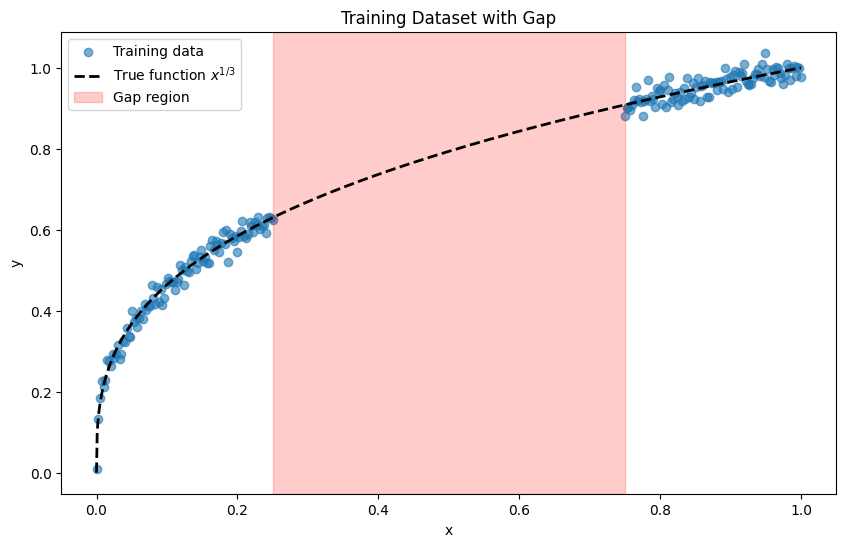

In [2]:
np.random.seed(42)

# Create data points in [0, 0.25] and [0.75, 1]
x1 = np.linspace(0, 0.25, 100)
x2 = np.linspace(0.75, 1, 100)
X_train = np.concatenate([x1, x2])

# Target function: x^(1/3) with noise
noise_std = 0.02
y_train = np.cbrt(X_train) + np.random.normal(0, noise_std, X_train.shape)

# Reshape for sklearn
X_train = X_train.reshape(-1, 1)

# Plot the dataset
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, alpha=0.6, label="Training data")
x_true = np.linspace(0, 1, 1000)
plt.plot(x_true, np.cbrt(x_true), "k--", label="True function $x^{1/3}$", linewidth=2)
plt.axvspan(0.25, 0.75, alpha=0.2, color="red", label="Gap region")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Training Dataset with Gap")
plt.show()

## Study 1: Activation Functions

Compare the performance of `tanh` and `relu` activation functions for fitting a small LLPR model to the dataset.

In [3]:
# Model parameters
hidden_dims = (32, 32)
n_epochs = 500
learning_rate = 1e-3

# Train model with tanh activation
print("Training with tanh activation...")
model_tanh = LLPRRegressor(
    hidden_dims=hidden_dims,
    activation="tanh",
    learning_rate=learning_rate,
    n_epochs=n_epochs,
    batch_size=32,
    early_stopping_patience=100,
    alpha_squared="auto",
    zeta_squared="auto",
    val_size=0.1,
    random_state=42,
)
model_tanh.fit(X_train, y_train)

# Train model with relu activation
print("\nTraining with relu activation...")
model_relu = LLPRRegressor(
    hidden_dims=hidden_dims,
    activation="relu",
    learning_rate=learning_rate,
    n_epochs=n_epochs,
    batch_size=32,
    early_stopping_patience=100,
    alpha_squared="auto",
    zeta_squared="auto",
    val_size=0.1,
    random_state=42,
)
model_relu.fit(X_train, y_train)

Training with tanh activation...
Early stopping at epoch 249
Calibrated: alpha²=1.62e-02, zeta²=6.16e-05, NLL=-2.6252

Training with relu activation...
Early stopping at epoch 337
Calibrated: alpha²=2.64e-02, zeta²=1.00e+00, NLL=-2.6454


LLPRRegressor(activation='relu', hidden_dims=(32, 32), n_epochs=500)

Note the very large zeta^2, that suggests a highly singular Hessian. When ζ² is large:
  (F^T F + ζ²I)^{-1} ≈ (ζ²I)^{-1} = (1/ζ²)I

  So the uncertainty becomes approximately:
  σ²★ ≈ α²/ζ² * ||f★||²

  This means the relu uncertainty is essentially just proportional to the
  feature norm squared, scaled by α²/ζ². The covariance structure from
  training data (F^T F) is almost completely washed out by the large
  regularization.

  The calibration found that ζ² = 1.0 gave the best NLL on the validation
  set - but this likely means the LLPR uncertainty framework is breaking
  down for relu. The model is saying "I can't use the covariance structure
  meaningfully, so I'll just regularize heavily and give roughly constant
  uncertainty."


In [4]:
# Predict on extended range
X_test = np.linspace(-4, 4, 500).reshape(-1, 1)

y_pred_tanh, y_std_tanh = model_tanh.predict_with_uncertainty(X_test)
y_pred_relu, y_std_relu = model_relu.predict_with_uncertainty(X_test)

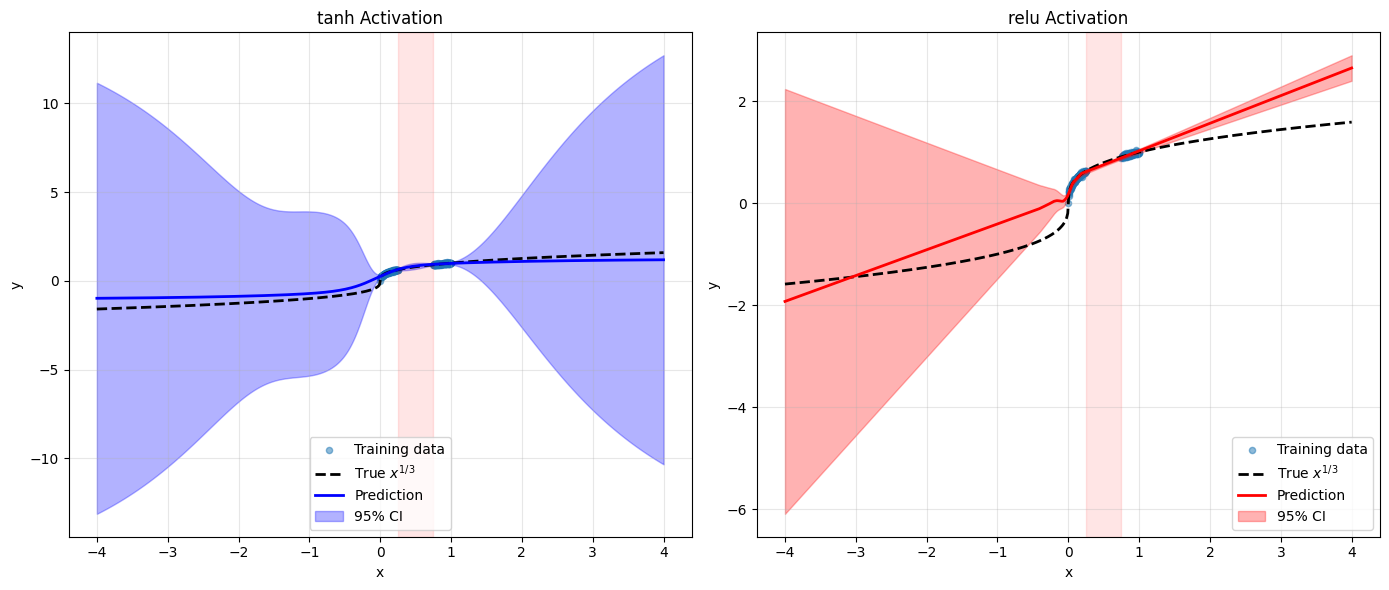

In [5]:
# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# True function for comparison
x_true = np.linspace(-4, 4, 500)
y_true = np.cbrt(x_true)

# Tanh plot
ax = axes[0]
ax.scatter(X_train, y_train, alpha=0.5, s=20, label="Training data")
ax.plot(x_true, y_true, "k--", label="True $x^{1/3}$", linewidth=2)
ax.plot(X_test, y_pred_tanh, "b-", label="Prediction", linewidth=2)
ax.fill_between(
    X_test.flatten(),
    y_pred_tanh - 2 * y_std_tanh,
    y_pred_tanh + 2 * y_std_tanh,
    alpha=0.3,
    color="blue",
    label="95% CI",
)
ax.axvspan(0.25, 0.75, alpha=0.1, color="red")
# ax.set_ylim(-3, 3)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend()
ax.set_title("tanh Activation")
ax.grid(True, alpha=0.3)

# ReLU plot
ax = axes[1]
ax.scatter(X_train, y_train, alpha=0.5, s=20, label="Training data")
ax.plot(x_true, y_true, "k--", label="True $x^{1/3}$", linewidth=2)
ax.plot(X_test, y_pred_relu, "r-", label="Prediction", linewidth=2)
ax.fill_between(
    X_test.flatten(),
    y_pred_relu - 2 * y_std_relu,
    y_pred_relu + 2 * y_std_relu,
    alpha=0.3,
    color="red",
    label="95% CI",
)
ax.axvspan(0.25, 0.75, alpha=0.1, color="red")
# ax.set_ylim(-3, 3)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend()
ax.set_title("relu Activation")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [6]:
# Print R² scores on training data
print(f"tanh R² score: {model_tanh.score(X_train, y_train):.4f}")
print(f"relu R² score: {model_relu.score(X_train, y_train):.4f}")

# Calibration parameters
print(f"\ntanh: alpha²={model_tanh.alpha_squared_:.2e}, zeta²={model_tanh.zeta_squared_:.2e}")
print(f"relu: alpha²={model_relu.alpha_squared_:.2e}, zeta²={model_relu.zeta_squared_:.2e}")

tanh R² score: 0.9852
relu R² score: 0.9913

tanh: alpha²=1.62e-02, zeta²=6.16e-05
relu: alpha²=2.64e-02, zeta²=1.00e+00


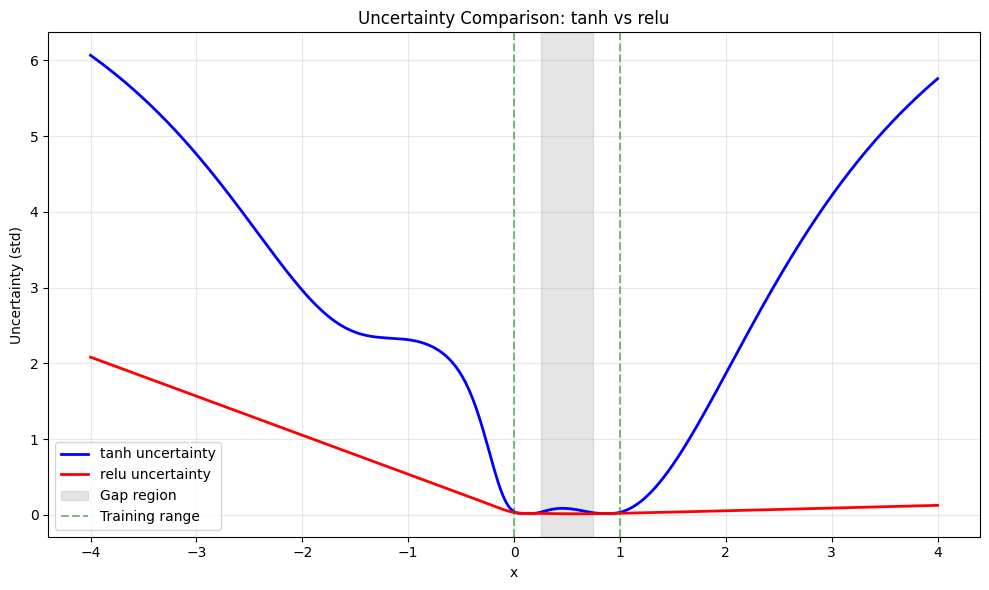

In [7]:
# Plot uncertainty comparison
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(X_test, y_std_tanh, "b-", label="tanh uncertainty", linewidth=2)
ax.plot(X_test, y_std_relu, "r-", label="relu uncertainty", linewidth=2)
ax.axvspan(0.25, 0.75, alpha=0.2, color="gray", label="Gap region")
ax.axvline(0, color="green", linestyle="--", alpha=0.5)
ax.axvline(1, color="green", linestyle="--", alpha=0.5, label="Training range")
ax.set_xlabel("x")
ax.set_ylabel("Uncertainty (std)")
ax.legend()
ax.set_title("Uncertainty Comparison: tanh vs relu")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

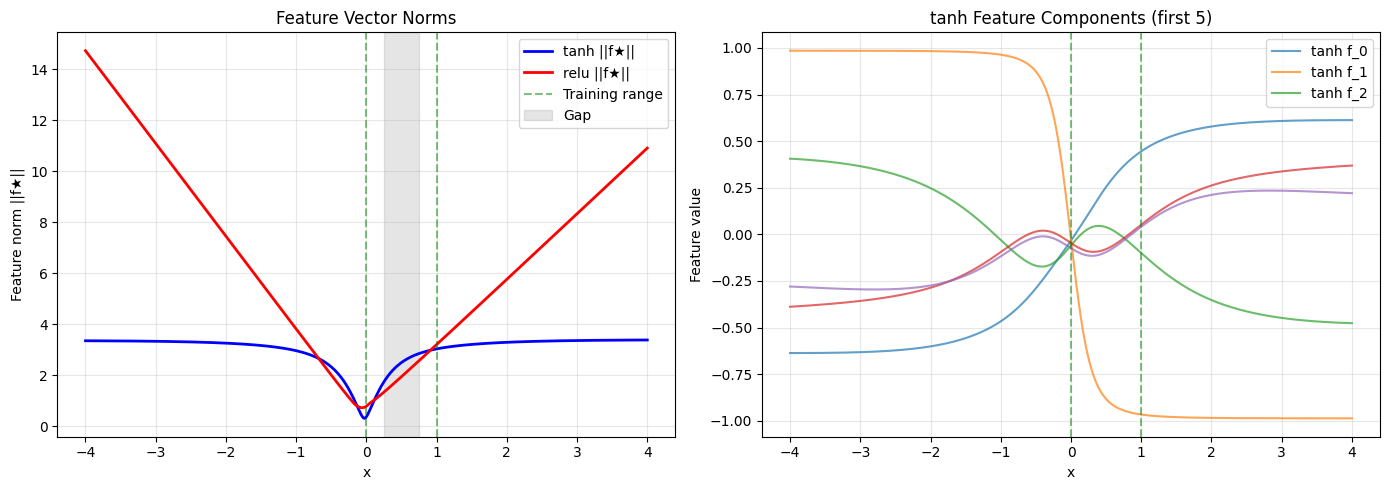

tanh feature norm at x=-3: 3.3505, at x=0.5: 0.4007, at x=3: 3.3810
relu feature norm at x=-3: 14.7368, at x=0.5: 0.7964, at x=3: 10.9146


In [8]:
# Investigate the feature vectors to understand uncertainty behavior
import jax.numpy as jnp

# Get features for test points
_, features_tanh = model_tanh.model_.apply(
    model_tanh.params_, jnp.array(X_test, dtype=jnp.float32), return_features=True
)
_, features_relu = model_relu.model_.apply(
    model_relu.params_, jnp.array(X_test, dtype=jnp.float32), return_features=True
)

# Compute feature norms
norm_tanh = np.linalg.norm(np.array(features_tanh), axis=1)
norm_relu = np.linalg.norm(np.array(features_relu), axis=1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Feature norms
ax = axes[0]
ax.plot(X_test, norm_tanh, "b-", label="tanh ||f★||", linewidth=2)
ax.plot(X_test, norm_relu, "r-", label="relu ||f★||", linewidth=2)
ax.axvline(0, color="green", linestyle="--", alpha=0.5)
ax.axvline(1, color="green", linestyle="--", alpha=0.5, label="Training range")
ax.axvspan(0.25, 0.75, alpha=0.2, color="gray", label="Gap")
ax.set_xlabel("x")
ax.set_ylabel("Feature norm ||f★||")
ax.legend()
ax.set_title("Feature Vector Norms")
ax.grid(True, alpha=0.3)

# Show a few feature components
ax = axes[1]
features_tanh_np = np.array(features_tanh)
features_relu_np = np.array(features_relu)
for i in range(min(5, features_tanh_np.shape[1])):
    ax.plot(X_test, features_tanh_np[:, i], alpha=0.7, label=f"tanh f_{i}" if i < 3 else None)
ax.axvline(0, color="green", linestyle="--", alpha=0.5)
ax.axvline(1, color="green", linestyle="--", alpha=0.5)
ax.set_xlabel("x")
ax.set_ylabel("Feature value")
ax.set_title("tanh Feature Components (first 5)")
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

print(
    f"tanh feature norm at x=-3: {norm_tanh[0]:.4f}, at x=0.5: {norm_tanh[250]:.4f}, at x=3: {norm_tanh[-1]:.4f}"
)
print(
    f"relu feature norm at x=-3: {norm_relu[0]:.4f}, at x=0.5: {norm_relu[250]:.4f}, at x=3: {norm_relu[-1]:.4f}"
)

## Study 2: Network Width

Explore how network width affects fitting and uncertainty for a single hidden layer LLPR model with tanh activation. We test widths of 2, 5, 10, 20, and 50 neurons.

In [9]:
# Train models with different widths
widths = [2, 5, 7, 10, 20, 50]
models_width = {}

for width in widths:
    print(f"Training with width={width}...")
    model = LLPRRegressor(
        hidden_dims=(width,),  # Single hidden layer
        activation="tanh",
        learning_rate=1e-3,
        n_epochs=500,
        batch_size=32,
        early_stopping_patience=100,
        alpha_squared="auto",
        zeta_squared="auto",
        val_size=0.1,
        random_state=42,
    )
    model.fit(X_train, y_train)
    models_width[width] = model
    print()

Training with width=2...
Early stopping at epoch 319
Calibrated: alpha²=1.13e-01, zeta²=1.00e-08, NLL=-2.0436

Training with width=5...
Early stopping at epoch 488
Calibrated: alpha²=2.64e-02, zeta²=3.79e-01, NLL=-2.6216

Training with width=7...
Calibrated: alpha²=1.62e-02, zeta²=8.86e-06, NLL=-2.5950

Training with width=10...
Early stopping at epoch 488
Calibrated: alpha²=1.00e-02, zeta²=2.34e-05, NLL=-2.6265

Training with width=20...
Early stopping at epoch 485
Calibrated: alpha²=1.00e-02, zeta²=6.16e-05, NLL=-2.6445

Training with width=50...
Early stopping at epoch 113
Calibrated: alpha²=1.62e-02, zeta²=4.28e-04, NLL=-2.5251



In [10]:
# Generate predictions for all models
predictions_width = {}
for width, model in models_width.items():
    y_pred, y_std = model.predict_with_uncertainty(X_test)
    predictions_width[width] = (y_pred, y_std)

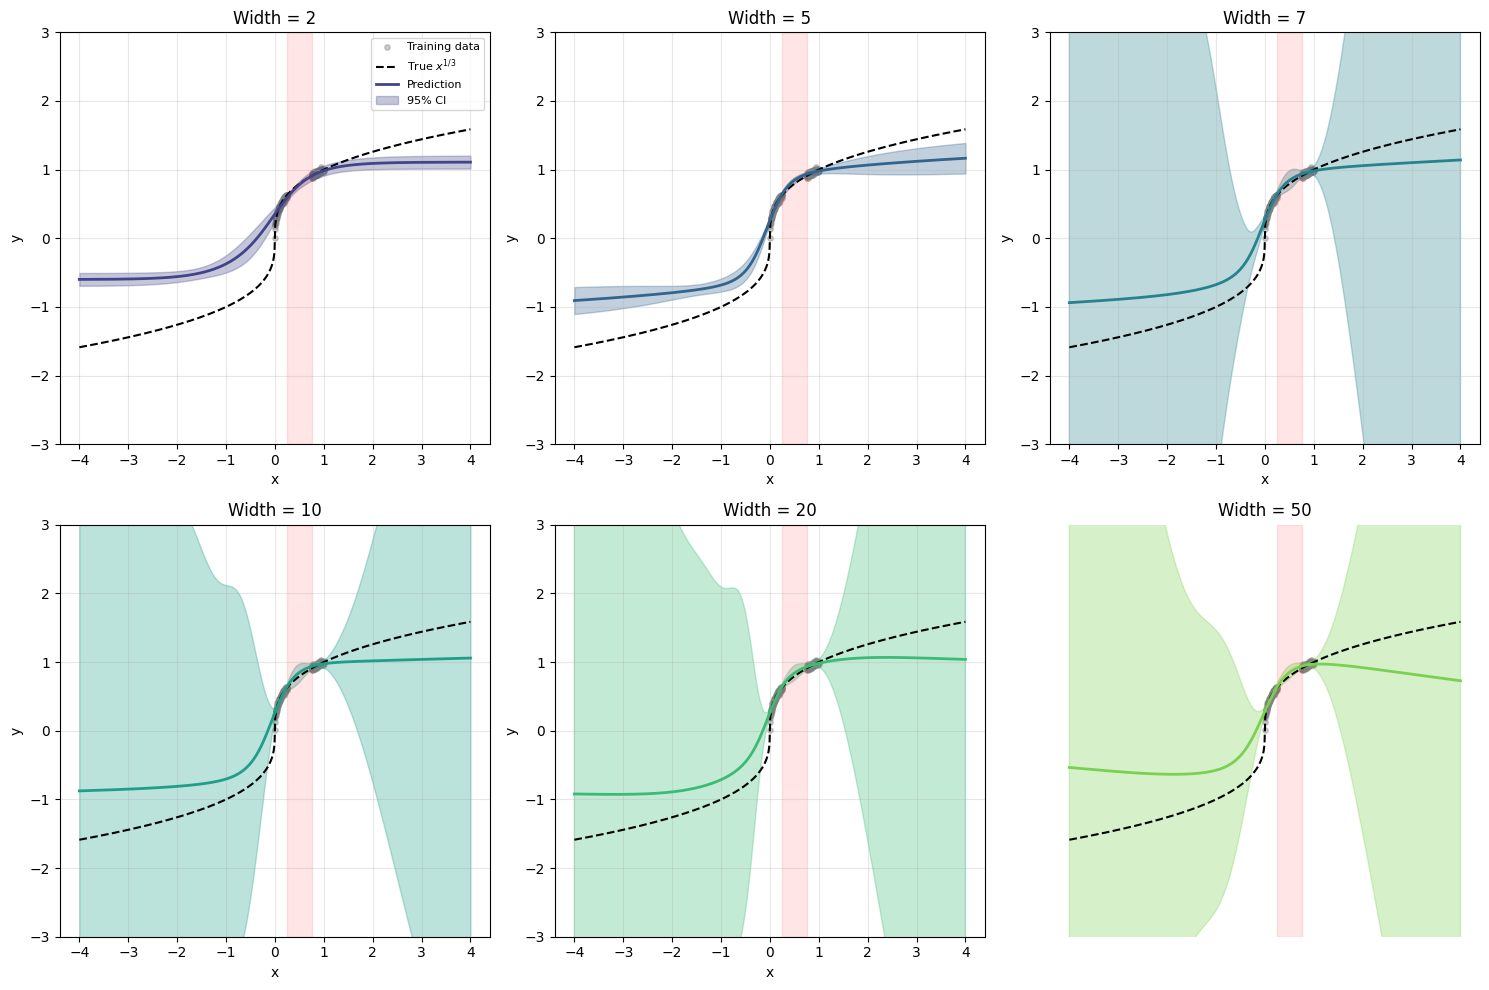

In [11]:
# Plot fit and uncertainty for each width
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

x_true = np.linspace(-4, 4, 500)
y_true = np.cbrt(x_true)

colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(widths)))

for i, (width, color) in enumerate(zip(widths, colors)):
    ax = axes[i]
    y_pred, y_std = predictions_width[width]

    ax.scatter(X_train, y_train, alpha=0.4, s=15, c="gray", label="Training data")
    ax.plot(x_true, y_true, "k--", label="True $x^{1/3}$", linewidth=1.5)
    ax.plot(X_test, y_pred, color=color, label="Prediction", linewidth=2)
    ax.fill_between(
        X_test.flatten(),
        y_pred - 2 * y_std,
        y_pred + 2 * y_std,
        alpha=0.3,
        color=color,
        label="95% CI",
    )
    ax.axvspan(0.25, 0.75, alpha=0.1, color="red")
    ax.set_ylim(-3, 3)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(f"Width = {width}")
    ax.grid(True, alpha=0.3)
    if i == 0:
        ax.legend(fontsize=8)

# Hide the 6th subplot
axes[5].axis("off")

plt.tight_layout()
plt.show()

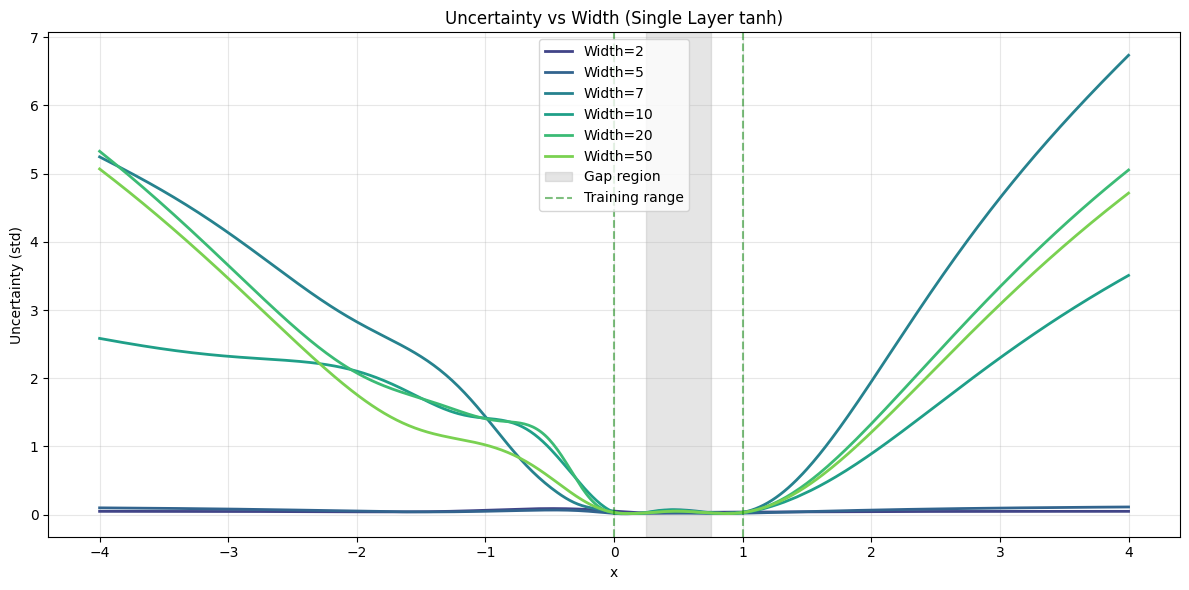

In [12]:
# Plot uncertainty comparison across widths
fig, ax = plt.subplots(figsize=(12, 6))

for width, color in zip(widths, colors):
    y_pred, y_std = predictions_width[width]
    ax.plot(X_test, y_std, color=color, label=f"Width={width}", linewidth=2)

ax.axvspan(0.25, 0.75, alpha=0.2, color="gray", label="Gap region")
ax.axvline(0, color="green", linestyle="--", alpha=0.5)
ax.axvline(1, color="green", linestyle="--", alpha=0.5, label="Training range")
ax.set_xlabel("x")
ax.set_ylabel("Uncertainty (std)")
ax.legend()
ax.set_title("Uncertainty vs Width (Single Layer tanh)")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Study 3: Network Depth

Explore how network depth affects fitting and uncertainty for a fixed width of 5 neurons with tanh activation. We test 1, 2, and 5 hidden layers.

In [13]:
# Train models with different depths (fixed width=5)
depths = [1, 2, 5, 10]
width = 5
models_depth = {}

for depth in depths:
    hidden_dims = tuple([width] * depth)
    print(f"Training with depth={depth} (hidden_dims={hidden_dims})...")
    model = LLPRRegressor(
        hidden_dims=hidden_dims,
        activation="tanh",
        learning_rate=1e-3,
        n_epochs=500,
        batch_size=32,
        early_stopping_patience=100,
        alpha_squared="auto",
        zeta_squared="auto",
        val_size=0.1,
        random_state=42,
    )
    model.fit(X_train, y_train)
    models_depth[depth] = model
    print()

Training with depth=1 (hidden_dims=(5,))...
Early stopping at epoch 488
Calibrated: alpha²=2.64e-02, zeta²=3.79e-01, NLL=-2.6216

Training with depth=2 (hidden_dims=(5, 5))...
Early stopping at epoch 410
Calibrated: alpha²=1.62e-02, zeta²=2.34e-05, NLL=-2.5780

Training with depth=5 (hidden_dims=(5, 5, 5, 5, 5))...
Calibrated: alpha²=1.62e-02, zeta²=2.98e-03, NLL=-2.7188

Training with depth=10 (hidden_dims=(5, 5, 5, 5, 5, 5, 5, 5, 5, 5))...
Calibrated: alpha²=1.62e-02, zeta²=7.85e-03, NLL=-2.7224



In [14]:
# Generate predictions for all depth models
X_test_depth = np.linspace(-4, 4, 500).reshape(-1, 1)
predictions_depth = {}
for depth, model in models_depth.items():
    y_pred, y_std = model.predict_with_uncertainty(X_test_depth)
    predictions_depth[depth] = (y_pred, y_std)

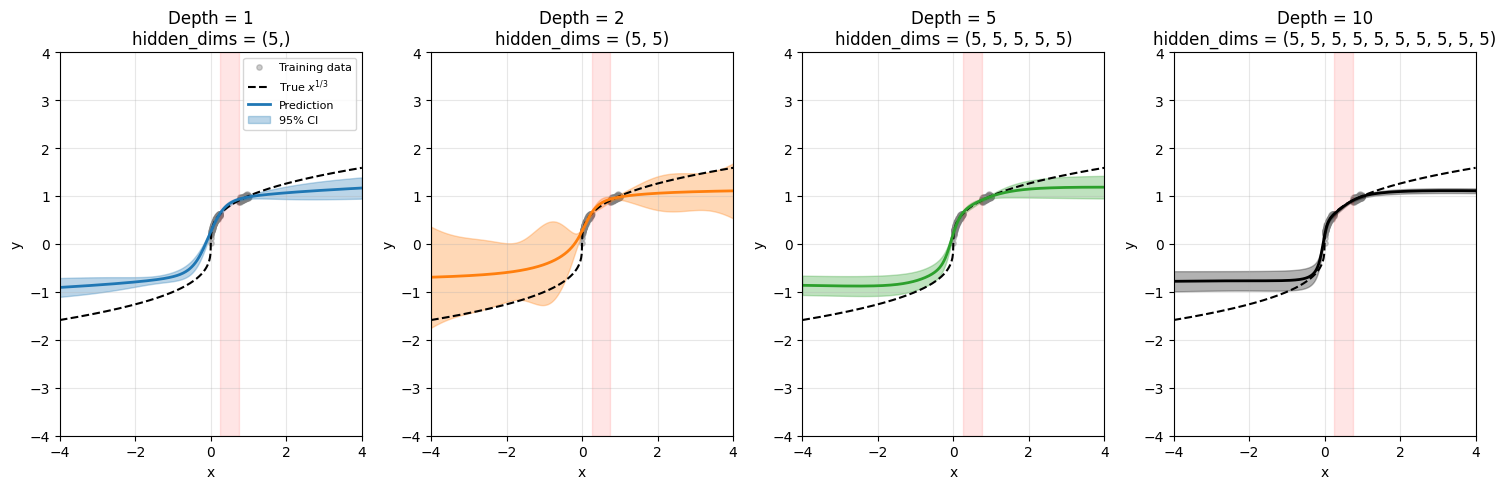

In [15]:
# Plot fit and uncertainty for each depth
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

x_true = np.linspace(-4, 4, 500)
y_true = np.cbrt(x_true)

colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "k"]
depth_width = 5  # Fixed width for depth study

for i, (depth, color) in enumerate(zip(depths, colors)):
    ax = axes[i]
    y_pred, y_std = predictions_depth[depth]

    ax.scatter(X_train, y_train, alpha=0.4, s=15, c="gray", label="Training data")
    ax.plot(x_true, y_true, "k--", label="True $x^{1/3}$", linewidth=1.5)
    ax.plot(X_test_depth, y_pred, color=color, label="Prediction", linewidth=2)
    ax.fill_between(
        X_test_depth.flatten(),
        y_pred - 2 * y_std,
        y_pred + 2 * y_std,
        alpha=0.3,
        color=color,
        label="95% CI",
    )
    ax.axvspan(0.25, 0.75, alpha=0.1, color="red")
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    hidden_dims = tuple([depth_width] * depth)
    ax.set_title(f"Depth = {depth}\nhidden_dims = {hidden_dims}")
    ax.grid(True, alpha=0.3)
    if i == 0:
        ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

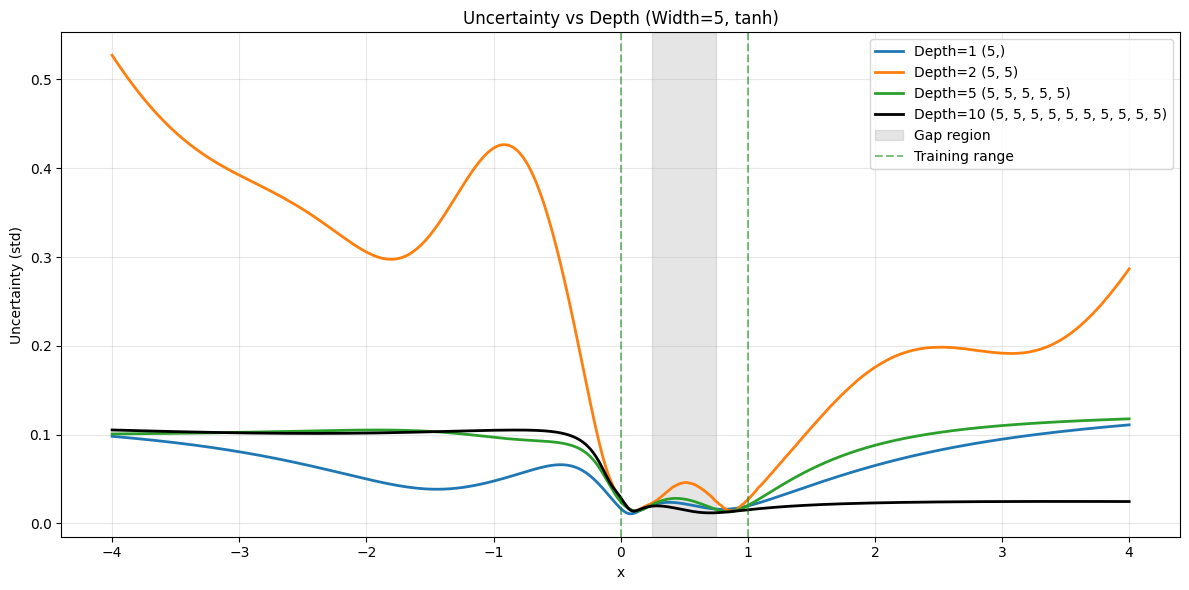

In [16]:
# Plot uncertainty comparison across depths
fig, ax = plt.subplots(figsize=(12, 6))

depth_width = 5  # Fixed width for depth study
for depth, color in zip(depths, colors):
    y_pred, y_std = predictions_depth[depth]
    hidden_dims = tuple([depth_width] * depth)
    ax.plot(X_test_depth, y_std, color=color, label=f"Depth={depth} {hidden_dims}", linewidth=2)

ax.axvspan(0.25, 0.75, alpha=0.2, color="gray", label="Gap region")
ax.axvline(0, color="green", linestyle="--", alpha=0.5)
ax.axvline(1, color="green", linestyle="--", alpha=0.5, label="Training range")
ax.set_xlabel("x")
ax.set_ylabel("Uncertainty (std)")
ax.legend()
ax.set_title("Uncertainty vs Depth (Width=5, tanh)")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [17]:
# Create metrics table for depth study
depth_width = 5  # Fixed width for depth study
metrics_data_depth = []
for depth in depths:
    model = models_depth[depth]
    y_pred, y_std = predictions_depth[depth]

    # R² on training data
    r2_train = model.score(X_train, y_train)

    # Get predictions on training data for calibration metrics
    y_pred_train, y_std_train = model.predict_with_uncertainty(X_train)
    cal_metrics = compute_calibration_metrics(y_train, y_pred_train, y_std_train)

    # Average uncertainty in different regions
    mask_train = ((X_test_depth.flatten() >= 0) & (X_test_depth.flatten() <= 0.25)) | (
        (X_test_depth.flatten() >= 0.75) & (X_test_depth.flatten() <= 1)
    )
    mask_gap = (X_test_depth.flatten() > 0.25) & (X_test_depth.flatten() < 0.75)
    mask_extrap = (X_test_depth.flatten() < 0) | (X_test_depth.flatten() > 1)

    avg_std_train_region = np.mean(y_std[mask_train])
    avg_std_gap = np.mean(y_std[mask_gap])
    avg_std_extrap = np.mean(y_std[mask_extrap])

    hidden_dims = tuple([depth_width] * depth)
    metrics_data_depth.append(
        {
            "Depth": depth,
            "Architecture": str(hidden_dims),
            "R² (train)": r2_train,
            "RMSE": cal_metrics["rmse"],
            "NLL": cal_metrics["nll"],
            "Cal. Error": cal_metrics["calibration_error"],
            "1σ Coverage": cal_metrics["fraction_within_1_sigma"],
            "α²": model.alpha_squared_,
            "ζ²": model.zeta_squared_,
            "Avg σ (train)": avg_std_train_region,
            "Avg σ (gap)": avg_std_gap,
            "Avg σ (extrap)": avg_std_extrap,
        }
    )

df_metrics_depth = pd.DataFrame(metrics_data_depth)
df_metrics_depth = df_metrics_depth.round(4)
print("Metrics Comparison for Different Depths (Width=5, tanh)")
print("=" * 100)
df_metrics_depth

Metrics Comparison for Different Depths (Width=5, tanh)


Depth                    Architecture  R² (train)    RMSE     NLL  \
0      1                            (5,)      0.9848  0.0323 -1.0789   
1      2                          (5, 5)      0.9836  0.0335 -1.7886   
2      5                 (5, 5, 5, 5, 5)      0.9896  0.0266 -2.0971   
3     10  (5, 5, 5, 5, 5, 5, 5, 5, 5, 5)      0.9924  0.0228 -2.3330   

   Cal. Error  1σ Coverage      α²      ζ²  Avg σ (train)  Avg σ (gap)  \
0      0.1665        0.465  0.0264  0.3793         0.0159       0.0210   
1      0.1098        0.535  0.0162  0.0000         0.0187       0.0375   
2      0.0898        0.540  0.0162  0.0030         0.0162       0.0243   
3      0.0648        0.580  0.0162  0.0078         0.0159       0.0155   

   Avg σ (extrap)  
0          0.0687  
1          0.2759  
2          0.0949  
3          0.0669

In [18]:
# Create metrics table
import pandas as pd

metrics_data = []
for width in widths:
    model = models_width[width]
    y_pred, y_std = predictions_width[width]

    # R² on training data
    r2_train = model.score(X_train, y_train)

    # Get predictions on training data for calibration metrics
    y_pred_train, y_std_train = model.predict_with_uncertainty(X_train)
    cal_metrics = compute_calibration_metrics(y_train, y_pred_train, y_std_train)

    # Average uncertainty in different regions
    mask_train = ((X_test.flatten() >= 0) & (X_test.flatten() <= 0.25)) | (
        (X_test.flatten() >= 0.75) & (X_test.flatten() <= 1)
    )
    mask_gap = (X_test.flatten() > 0.25) & (X_test.flatten() < 0.75)
    mask_extrap = (X_test.flatten() < 0) | (X_test.flatten() > 1)

    avg_std_train_region = np.mean(y_std[mask_train])
    avg_std_gap = np.mean(y_std[mask_gap])
    avg_std_extrap = np.mean(y_std[mask_extrap])

    metrics_data.append(
        {
            "Width": width,
            "R² (train)": r2_train,
            "RMSE": cal_metrics["rmse"],
            "NLL": cal_metrics["nll"],
            "Cal. Error": cal_metrics["calibration_error"],
            "1σ Coverage": cal_metrics["fraction_within_1_sigma"],
            "α²": model.alpha_squared_,
            "ζ²": model.zeta_squared_,
            "Avg σ (train)": avg_std_train_region,
            "Avg σ (gap)": avg_std_gap,
            "Avg σ (extrap)": avg_std_extrap,
        }
    )

df_metrics = pd.DataFrame(metrics_data)
df_metrics = df_metrics.round(4)
print("Metrics Comparison for Different Widths (Single Layer tanh)")
print("=" * 100)
df_metrics

Metrics Comparison for Different Widths (Single Layer tanh)


Width  R² (train)    RMSE     NLL  Cal. Error  1σ Coverage      α²      ζ²  \
0      2      0.9643  0.0494 -1.6997      0.0215        0.675  0.1129  0.0000   
1      5      0.9848  0.0323 -1.0789      0.1665        0.465  0.0264  0.3793   
2      7      0.9844  0.0326 -1.9625      0.0698        0.590  0.0162  0.0000   
3     10      0.9841  0.0330 -1.9188      0.1015        0.535  0.0100  0.0000   
4     20      0.9849  0.0321 -1.7080      0.1132        0.570  0.0100  0.0001   
5     50      0.9810  0.0361 -1.7403      0.1332        0.460  0.0162  0.0004   

   Avg σ (train)  Avg σ (gap)  Avg σ (extrap)  
0         0.0346       0.0264          0.0487  
1         0.0159       0.0210          0.0687  
2         0.0207       0.0523          2.9755  
3         0.0190       0.0508          1.7375  
4         0.0183       0.0412          2.4359  
5         0.0188       0.0388          2.1850

## Study 4: Shomate Polynomial Features

Instead of using raw x as input, we expand the input to Shomate polynomial features. The Shomate equation uses features: $[t, t^2, t^3, t^4, 1/t]$ where $t = T/1000$ for temperature T.

For our problem, we'll use analogous features: $[x, x^2, x^3, x^4, 1/(x+\epsilon)]$ where $\epsilon$ is a small constant to avoid division by zero.

This explores how input feature expansion affects LLPR uncertainty behavior.

In [19]:
def shomate_features(x, epsilon=0.1):
    """
    Generate Shomate-style polynomial features.
    Input x can be 1D array or 2D array with shape (n, 1).
    Returns features: [x, x^2, x^3, x^4, 1/(x+epsilon)]
    """
    x = np.asarray(x).flatten()
    return np.column_stack([x, x**2, x**3, x**4, 1.0 / (x + epsilon)])


# Create Shomate features for training data
x_train_raw = X_train.flatten()
X_train_shomate = shomate_features(x_train_raw)

print(f"Original input shape: {X_train.shape}")
print(f"Shomate features shape: {X_train_shomate.shape}")
print("\nFeature names: [x, x², x³, x⁴, 1/(x+ε)]")
print("\nExample features for x=0.5:")
print(shomate_features(np.array([0.5])))

Original input shape: (200, 1)
Shomate features shape: (200, 5)

Feature names: [x, x², x³, x⁴, 1/(x+ε)]

Example features for x=0.5:
[[0.5        0.25       0.125      0.0625     1.66666667]]


In [20]:
# Train LLPR model with Shomate features
# Compare different architectures

architectures = {
    "shallow_narrow": (8,),
    "shallow_wide": (32,),
    "deep_narrow": (8, 8, 8),
    "deep_wide": (32, 32),
}

models_shomate = {}

for name, hidden_dims in architectures.items():
    print(f"Training {name} with hidden_dims={hidden_dims}...")
    model = LLPRRegressor(
        hidden_dims=hidden_dims,
        activation="tanh",
        learning_rate=1e-3,
        n_epochs=500,
        batch_size=32,
        early_stopping_patience=100,
        alpha_squared="auto",
        zeta_squared="auto",
        val_size=0.1,
        random_state=42,
    )
    model.fit(X_train_shomate, y_train)
    models_shomate[name] = model
    print()

Training shallow_narrow with hidden_dims=(8,)...
Early stopping at epoch 304
Calibrated: alpha²=1.00e-02, zeta²=7.85e-03, NLL=-2.7871

Training shallow_wide with hidden_dims=(32,)...
Calibrated: alpha²=1.00e-02, zeta²=7.85e-03, NLL=-2.6615

Training deep_narrow with hidden_dims=(8, 8, 8)...
Calibrated: alpha²=1.00e-02, zeta²=2.34e-05, NLL=-2.6893

Training deep_wide with hidden_dims=(32, 32)...
Early stopping at epoch 159
Calibrated: alpha²=1.00e-02, zeta²=7.85e-03, NLL=-2.7380



In [21]:
# Generate test data with Shomate features
X_test_shomate_raw = np.linspace(-4, 4, 500)
X_test_shomate = shomate_features(X_test_shomate_raw)

# Get predictions for all models
predictions_shomate = {}
for name, model in models_shomate.items():
    y_pred, y_std = model.predict_with_uncertainty(X_test_shomate)
    predictions_shomate[name] = (y_pred, y_std)

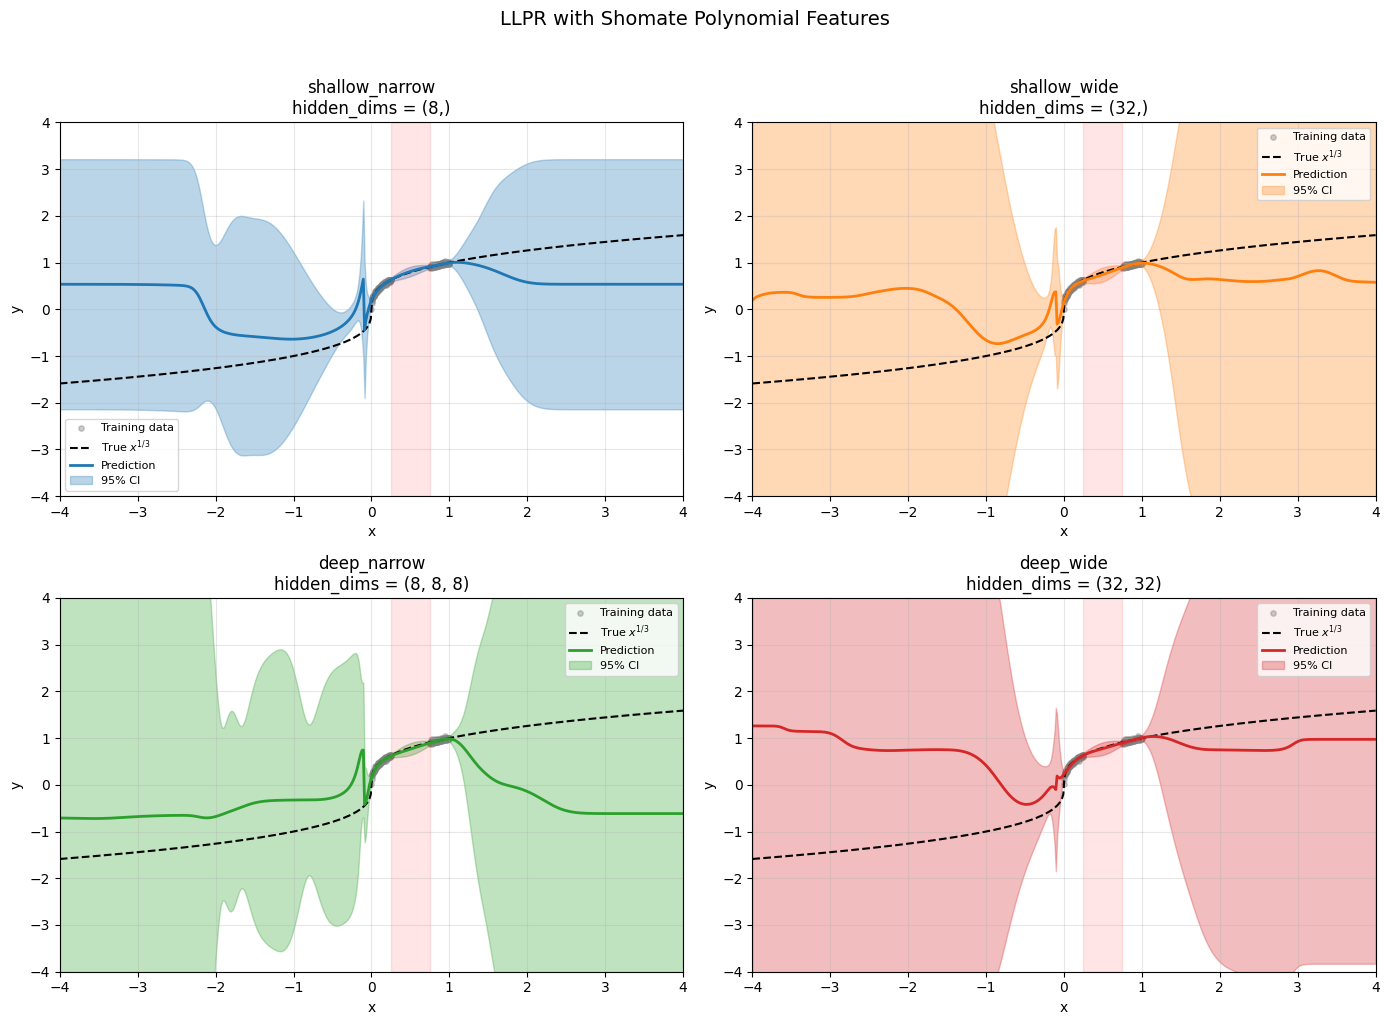

In [22]:
# Plot fit and uncertainty for each architecture
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

x_true = np.linspace(-4, 4, 500)
y_true = np.cbrt(x_true)

colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]

for i, (name, color) in enumerate(zip(architectures.keys(), colors)):
    ax = axes[i]
    y_pred, y_std = predictions_shomate[name]
    hidden_dims = architectures[name]

    ax.scatter(x_train_raw, y_train, alpha=0.4, s=15, c="gray", label="Training data")
    ax.plot(x_true, y_true, "k--", label="True $x^{1/3}$", linewidth=1.5)
    ax.plot(X_test_shomate_raw, y_pred, color=color, label="Prediction", linewidth=2)
    ax.fill_between(
        X_test_shomate_raw,
        y_pred - 2 * y_std,
        y_pred + 2 * y_std,
        alpha=0.3,
        color=color,
        label="95% CI",
    )
    ax.axvspan(0.25, 0.75, alpha=0.1, color="red")
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(f"{name}\nhidden_dims = {hidden_dims}")
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)

plt.suptitle("LLPR with Shomate Polynomial Features", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

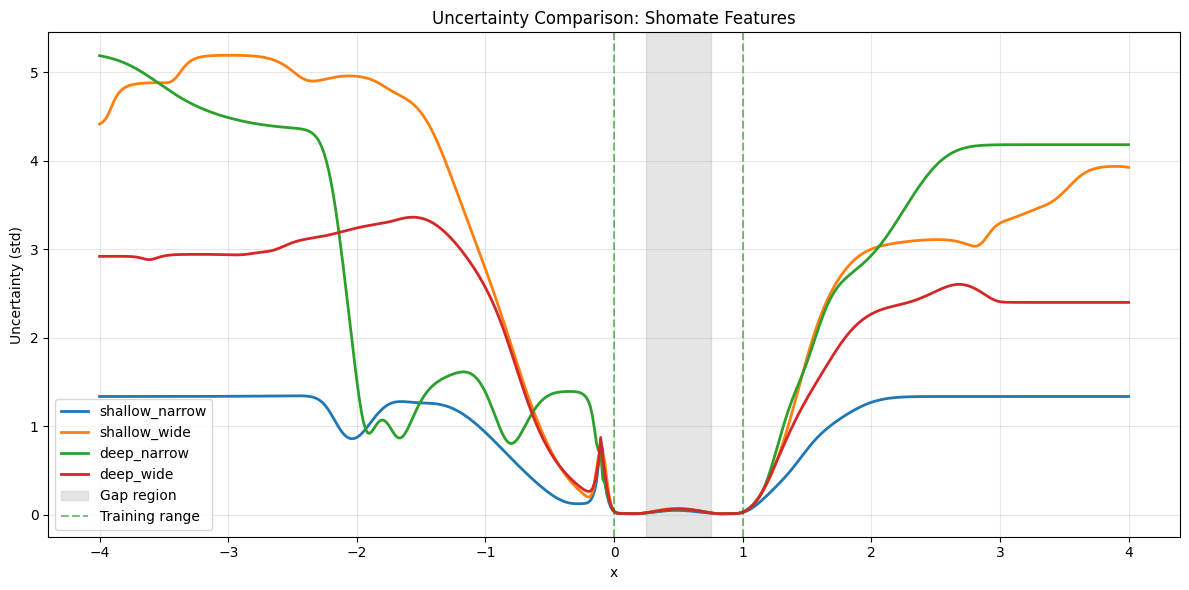

In [23]:
# Plot uncertainty comparison
fig, ax = plt.subplots(figsize=(12, 6))

for name, color in zip(architectures.keys(), colors):
    y_pred, y_std = predictions_shomate[name]
    ax.plot(X_test_shomate_raw, y_std, color=color, label=f"{name}", linewidth=2)

ax.axvspan(0.25, 0.75, alpha=0.2, color="gray", label="Gap region")
ax.axvline(0, color="green", linestyle="--", alpha=0.5)
ax.axvline(1, color="green", linestyle="--", alpha=0.5, label="Training range")
ax.set_xlabel("x")
ax.set_ylabel("Uncertainty (std)")
ax.legend()
ax.set_title("Uncertainty Comparison: Shomate Features")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [24]:
# Metrics table for Shomate features
metrics_data_shomate = []
for name, hidden_dims in architectures.items():
    model = models_shomate[name]
    y_pred, y_std = predictions_shomate[name]

    # R² on training data
    r2_train = model.score(X_train_shomate, y_train)

    # Get predictions on training data for calibration metrics
    y_pred_train, y_std_train = model.predict_with_uncertainty(X_train_shomate)
    cal_metrics = compute_calibration_metrics(y_train, y_pred_train, y_std_train)

    # Average uncertainty in different regions
    mask_train = ((X_test_shomate_raw >= 0) & (X_test_shomate_raw <= 0.25)) | (
        (X_test_shomate_raw >= 0.75) & (X_test_shomate_raw <= 1)
    )
    mask_gap = (X_test_shomate_raw > 0.25) & (X_test_shomate_raw < 0.75)
    mask_extrap = (X_test_shomate_raw < 0) | (X_test_shomate_raw > 1)

    avg_std_train_region = np.mean(y_std[mask_train])
    avg_std_gap = np.mean(y_std[mask_gap])
    avg_std_extrap = np.mean(y_std[mask_extrap])

    metrics_data_shomate.append(
        {
            "Model": name,
            "Architecture": str(hidden_dims),
            "R² (train)": r2_train,
            "RMSE": cal_metrics["rmse"],
            "NLL": cal_metrics["nll"],
            "Cal. Error": cal_metrics["calibration_error"],
            "1σ Coverage": cal_metrics["fraction_within_1_sigma"],
            "α²": model.alpha_squared_,
            "ζ²": model.zeta_squared_,
            "Avg σ (train)": avg_std_train_region,
            "Avg σ (gap)": avg_std_gap,
            "Avg σ (extrap)": avg_std_extrap,
        }
    )

df_metrics_shomate = pd.DataFrame(metrics_data_shomate)
df_metrics_shomate = df_metrics_shomate.round(4)
print("Metrics Comparison: Shomate Polynomial Features")
print("=" * 100)
df_metrics_shomate

Metrics Comparison: Shomate Polynomial Features


Model Architecture  R² (train)    RMSE     NLL  Cal. Error  \
0  shallow_narrow         (8,)      0.9918  0.0236 -2.3506      0.0682   
1    shallow_wide        (32,)      0.9927  0.0224 -2.4030      0.0565   
2     deep_narrow    (8, 8, 8)      0.9929  0.0221 -2.4149      0.0548   
3       deep_wide     (32, 32)      0.9899  0.0263 -2.2911      0.0682   

   1σ Coverage    α²      ζ²  Avg σ (train)  Avg σ (gap)  Avg σ (extrap)  
0        0.575  0.01  0.0078         0.0159       0.0394          1.0737  
1        0.600  0.01  0.0078         0.0174       0.0553          3.3841  
2        0.605  0.01  0.0000         0.0171       0.0483          2.9723  
3        0.575  0.01  0.0078         0.0170       0.0506          2.3275

Comparing raw input vs Shomate features with (32, 32) architecture:



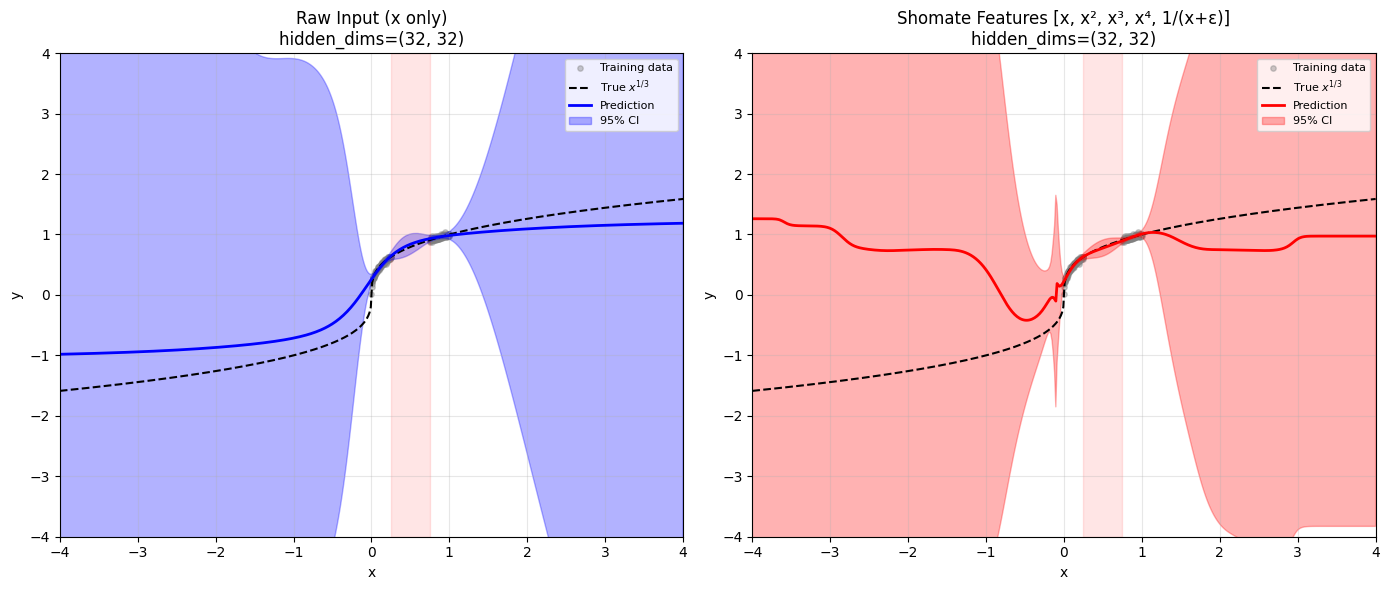

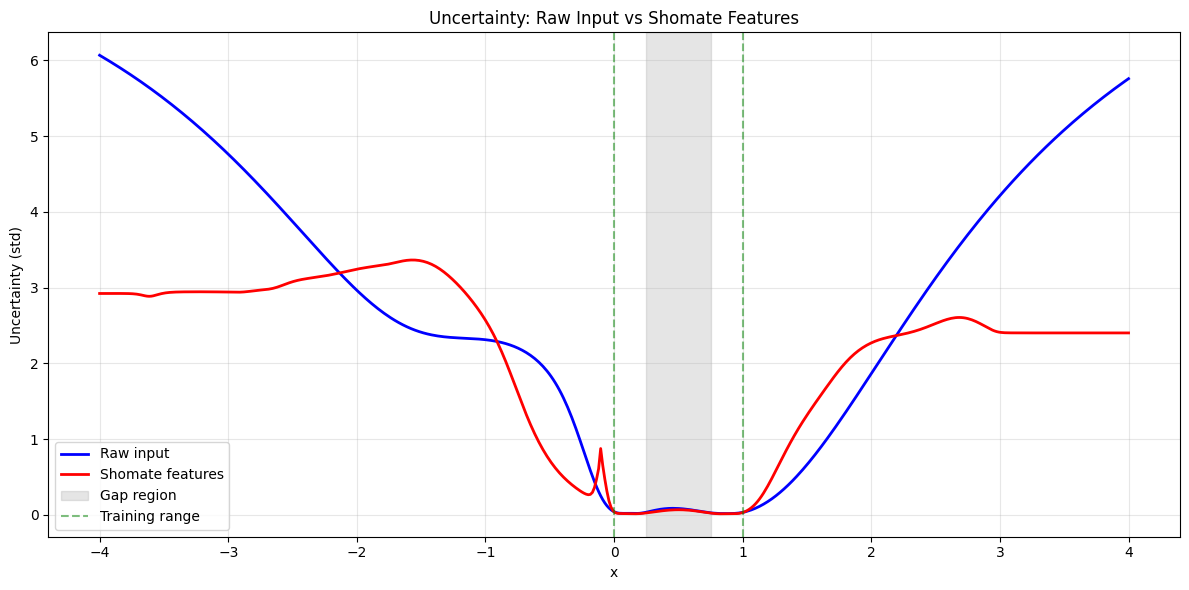

In [25]:
# Compare Shomate features vs raw input for the same architecture
# Using (32, 32) architecture for fair comparison

print("Comparing raw input vs Shomate features with (32, 32) architecture:\n")

# Raw input model (from Study 1)
y_pred_raw, y_std_raw = model_tanh.predict_with_uncertainty(X_test)

# Shomate model
y_pred_shom, y_std_shom = predictions_shomate["deep_wide"]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

x_true = np.linspace(-4, 4, 500)
y_true = np.cbrt(x_true)

# Raw input
ax = axes[0]
ax.scatter(X_train, y_train, alpha=0.4, s=15, c="gray", label="Training data")
ax.plot(x_true, y_true, "k--", label="True $x^{1/3}$", linewidth=1.5)
ax.plot(X_test, y_pred_raw, "b-", label="Prediction", linewidth=2)
ax.fill_between(
    X_test.flatten(),
    y_pred_raw - 2 * y_std_raw,
    y_pred_raw + 2 * y_std_raw,
    alpha=0.3,
    color="blue",
    label="95% CI",
)
ax.axvspan(0.25, 0.75, alpha=0.1, color="red")
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Raw Input (x only)\nhidden_dims=(32, 32)")
ax.grid(True, alpha=0.3)
ax.legend(fontsize=8)

# Shomate features
ax = axes[1]
ax.scatter(x_train_raw, y_train, alpha=0.4, s=15, c="gray", label="Training data")
ax.plot(x_true, y_true, "k--", label="True $x^{1/3}$", linewidth=1.5)
ax.plot(X_test_shomate_raw, y_pred_shom, "r-", label="Prediction", linewidth=2)
ax.fill_between(
    X_test_shomate_raw,
    y_pred_shom - 2 * y_std_shom,
    y_pred_shom + 2 * y_std_shom,
    alpha=0.3,
    color="red",
    label="95% CI",
)
ax.axvspan(0.25, 0.75, alpha=0.1, color="red")
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Shomate Features [x, x², x³, x⁴, 1/(x+ε)]\nhidden_dims=(32, 32)")
ax.grid(True, alpha=0.3)
ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

# Uncertainty comparison
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(X_test, y_std_raw, "b-", label="Raw input", linewidth=2)
ax.plot(X_test_shomate_raw, y_std_shom, "r-", label="Shomate features", linewidth=2)
ax.axvspan(0.25, 0.75, alpha=0.2, color="gray", label="Gap region")
ax.axvline(0, color="green", linestyle="--", alpha=0.5)
ax.axvline(1, color="green", linestyle="--", alpha=0.5, label="Training range")
ax.set_xlabel("x")
ax.set_ylabel("Uncertainty (std)")
ax.legend()
ax.set_title("Uncertainty: Raw Input vs Shomate Features")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Study 5: High-Dimensional Input with Sparse Training Data

**Pathology:** LLPR uncertainty depends on how well training data covers the feature space. With high-dimensional inputs but limited training data, F^T F becomes ill-conditioned (low rank relative to its dimension). The model may:
1. Rely heavily on ζ² regularization, washing out meaningful uncertainty structure
2. Show overconfidence because the regularized inverse doesn't properly capture which directions are poorly covered
3. Have calibration fail because the validation set also doesn't cover the space well

**Setup:** We expand our 1D input to 20 dimensions using random Fourier features, but keep only 200 training points. This creates a scenario where the feature space is vastly undersampled.

In [26]:
# Create high-dimensional random Fourier features
np.random.seed(123)

n_fourier_features = 20
# Random frequencies for Fourier features
frequencies = np.random.randn(n_fourier_features) * 3


def fourier_features(x):
    """
    Generate random Fourier features: [sin(w1*x), cos(w1*x), sin(w2*x), cos(w2*x), ...]
    """
    x = np.asarray(x).flatten()
    features = []
    for w in frequencies[: n_fourier_features // 2]:
        features.append(np.sin(w * x))
        features.append(np.cos(w * x))
    return np.column_stack(features)


# Create high-dimensional training data
X_train_highdim = fourier_features(X_train.flatten())
X_test_highdim = fourier_features(np.linspace(-4, 4, 500))

print(f"Training data shape: {X_train_highdim.shape}")
print(f"Number of training points: {X_train_highdim.shape[0]}")
print(f"Number of input features: {X_train_highdim.shape[1]}")
print(f"Ratio (samples / features): {X_train_highdim.shape[0] / X_train_highdim.shape[1]:.1f}")

Training data shape: (200, 20)
Number of training points: 200
Number of input features: 20
Ratio (samples / features): 10.0


In [27]:
# Train models with different last-layer widths on high-dim input
# The last-layer width determines the dimension of f★

highdim_widths = [5, 20, 50, 100]
models_highdim = {}

for width in highdim_widths:
    print(f"Training with last-layer width={width} on {n_fourier_features}D input...")
    model = LLPRRegressor(
        hidden_dims=(32, width),  # 32 neurons in first layer, variable last layer
        activation="tanh",
        learning_rate=1e-3,
        n_epochs=500,
        batch_size=32,
        early_stopping_patience=100,
        alpha_squared="auto",
        zeta_squared="auto",
        val_size=0.1,
        random_state=42,
    )
    model.fit(X_train_highdim, y_train)
    models_highdim[width] = model
    print()

Training with last-layer width=5 on 20D input...
Early stopping at epoch 429
Calibrated: alpha²=1.62e-02, zeta²=1.00e+00, NLL=-2.6938

Training with last-layer width=20 on 20D input...
Early stopping at epoch 326
Calibrated: alpha²=1.00e-02, zeta²=3.79e-01, NLL=-2.7055

Training with last-layer width=50 on 20D input...
Early stopping at epoch 217
Calibrated: alpha²=1.00e-02, zeta²=1.00e+00, NLL=-2.6875

Training with last-layer width=100 on 20D input...
Early stopping at epoch 185
Calibrated: alpha²=1.00e-02, zeta²=1.00e+00, NLL=-2.7291



In [28]:
# Generate predictions
X_test_raw_highdim = np.linspace(-4, 4, 500)
predictions_highdim = {}
for width, model in models_highdim.items():
    y_pred, y_std = model.predict_with_uncertainty(X_test_highdim)
    predictions_highdim[width] = (y_pred, y_std)

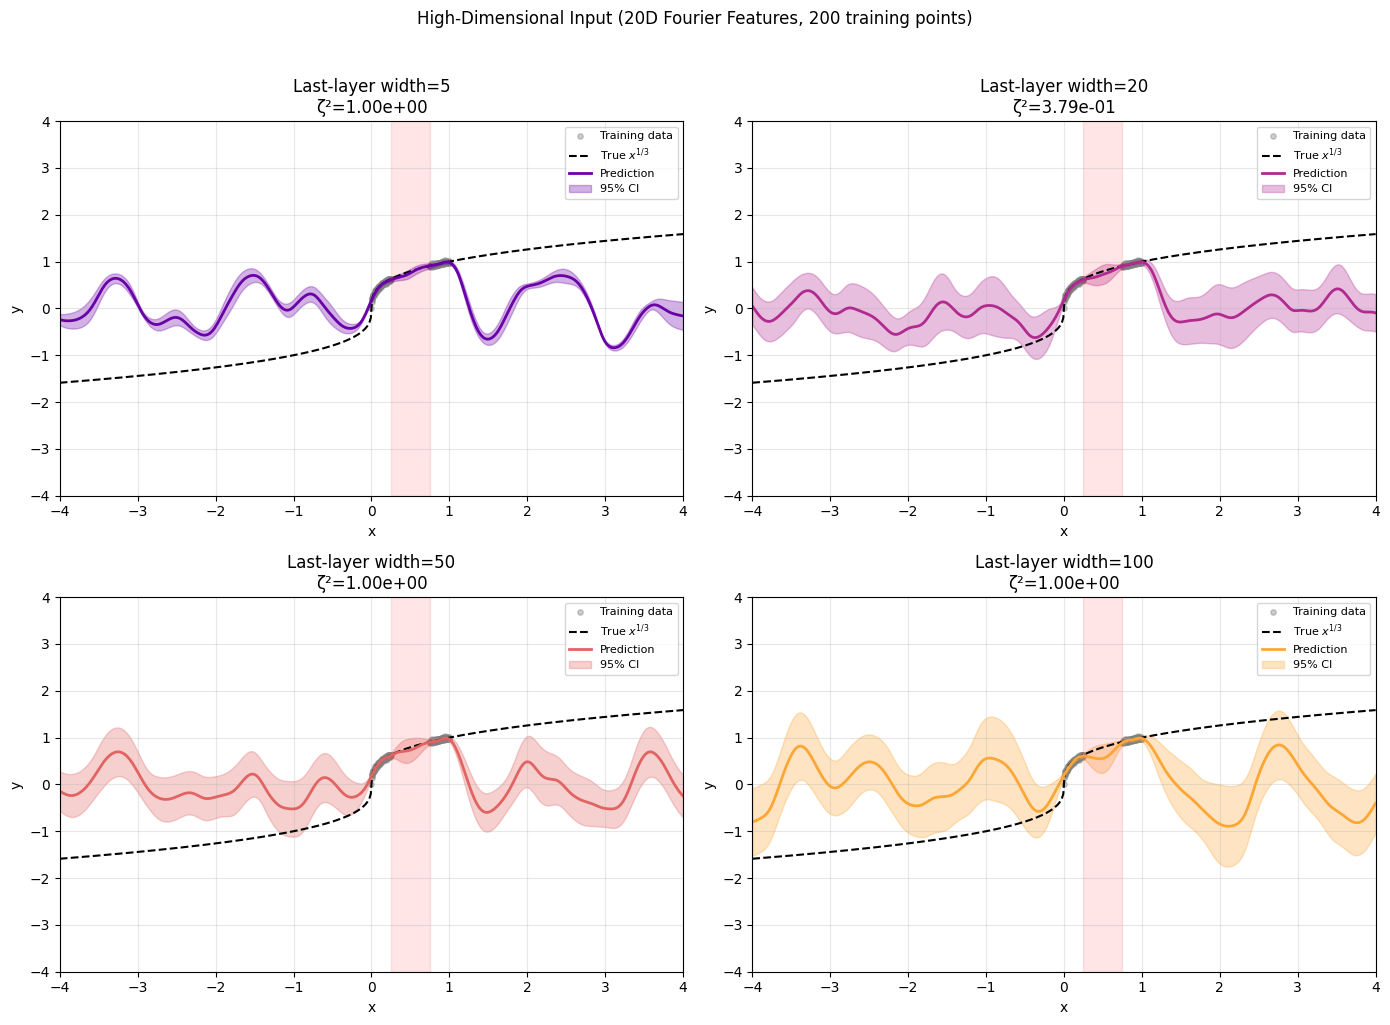

In [29]:
# Plot results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

x_true = np.linspace(-4, 4, 500)
y_true = np.cbrt(x_true)
x_train_raw = X_train.flatten()

colors = plt.cm.plasma(np.linspace(0.2, 0.8, len(highdim_widths)))

for i, (width, color) in enumerate(zip(highdim_widths, colors)):
    ax = axes[i]
    y_pred, y_std = predictions_highdim[width]
    model = models_highdim[width]

    ax.scatter(x_train_raw, y_train, alpha=0.4, s=15, c="gray", label="Training data")
    ax.plot(x_true, y_true, "k--", label="True $x^{1/3}$", linewidth=1.5)
    ax.plot(X_test_raw_highdim, y_pred, color=color, label="Prediction", linewidth=2)
    ax.fill_between(
        X_test_raw_highdim,
        y_pred - 2 * y_std,
        y_pred + 2 * y_std,
        alpha=0.3,
        color=color,
        label="95% CI",
    )
    ax.axvspan(0.25, 0.75, alpha=0.1, color="red")
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(f"Last-layer width={width}\nζ²={model.zeta_squared_:.2e}")
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)

plt.suptitle(
    f"High-Dimensional Input ({n_fourier_features}D Fourier Features, 200 training points)",
    fontsize=12,
    y=1.02,
)
plt.tight_layout()
plt.show()

## Study 6: Adversarial Interpolation Region

**Pathology:** LLPR measures uncertainty based on feature space coverage. If a region has features that look "similar" to training features (small `f★ᵀ(F^T F)^{-1}f★`), LLPR will report low uncertainty - even if the model's prediction is completely wrong there.

**Setup:** We create a scenario where:
1. Training data comes from two different functions in two regions
2. The gap region would naturally interpolate incorrectly
3. But the gap features might align with training feature directions, causing false confidence

We train on `x^(1/3)` for x < 0.25 and `1 - (1-x)^(1/3)` for x > 0.75. These have different shapes but could produce overlapping feature representations, making the model overconfident in the gap where it interpolates incorrectly.

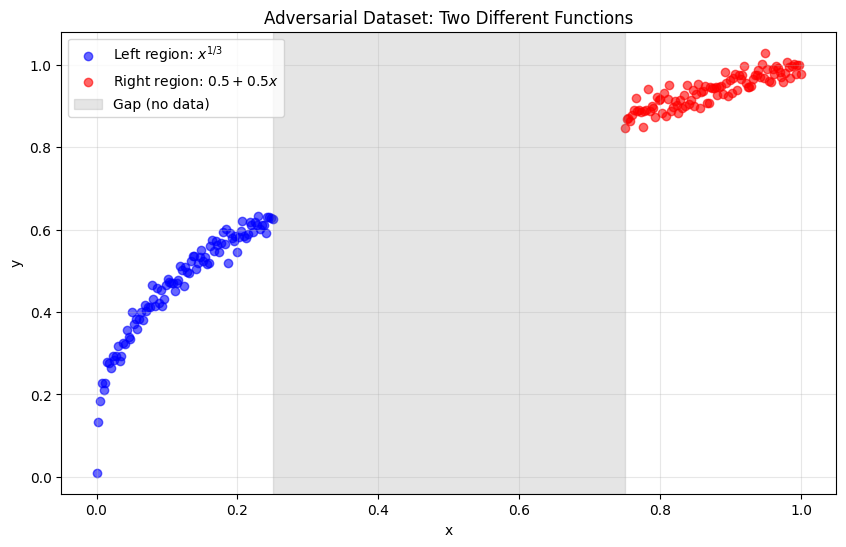

Note: The model must interpolate between two incompatible functions.
LLPR might be overconfident in the gap if features there look 'normal'.


In [30]:
# Create adversarial dataset with two different functions
np.random.seed(42)

# Left region: x^(1/3)
x_left = np.linspace(0, 0.25, 100)
y_left = np.cbrt(x_left) + np.random.normal(0, 0.02, x_left.shape)

# Right region: different function - let's use a linear function that doesn't match
# This creates a situation where interpolation will be wrong
x_right = np.linspace(0.75, 1.0, 100)
y_right = 0.5 + 0.5 * x_right + np.random.normal(0, 0.02, x_right.shape)  # Linear function

X_train_adv = np.concatenate([x_left, x_right]).reshape(-1, 1)
y_train_adv = np.concatenate([y_left, y_right])

# The "true" function in the gap is undefined/ambiguous
# But we can define what a reasonable interpolation might look like vs what the model does

# Plot the adversarial dataset
plt.figure(figsize=(10, 6))
plt.scatter(x_left, y_left, alpha=0.6, label="Left region: $x^{1/3}$", c="blue")
plt.scatter(x_right, y_right, alpha=0.6, label="Right region: $0.5 + 0.5x$", c="red")
plt.axvspan(0.25, 0.75, alpha=0.2, color="gray", label="Gap (no data)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Adversarial Dataset: Two Different Functions")
plt.grid(True, alpha=0.3)
plt.show()

print("Note: The model must interpolate between two incompatible functions.")
print("LLPR might be overconfident in the gap if features there look 'normal'.")

In [31]:
# Train model on adversarial data
print("Training on adversarial dataset...")
model_adv = LLPRRegressor(
    hidden_dims=(32, 32),
    activation="tanh",
    learning_rate=1e-3,
    n_epochs=500,
    batch_size=32,
    early_stopping_patience=100,
    alpha_squared="auto",
    zeta_squared="auto",
    val_size=0.1,
    random_state=42,
)
model_adv.fit(X_train_adv, y_train_adv)

# Generate predictions
X_test_adv = np.linspace(-0.5, 1.5, 500).reshape(-1, 1)
y_pred_adv, y_std_adv = model_adv.predict_with_uncertainty(X_test_adv)

Training on adversarial dataset...
Calibrated: alpha²=1.00e-02, zeta²=6.16e-05, NLL=-2.7109


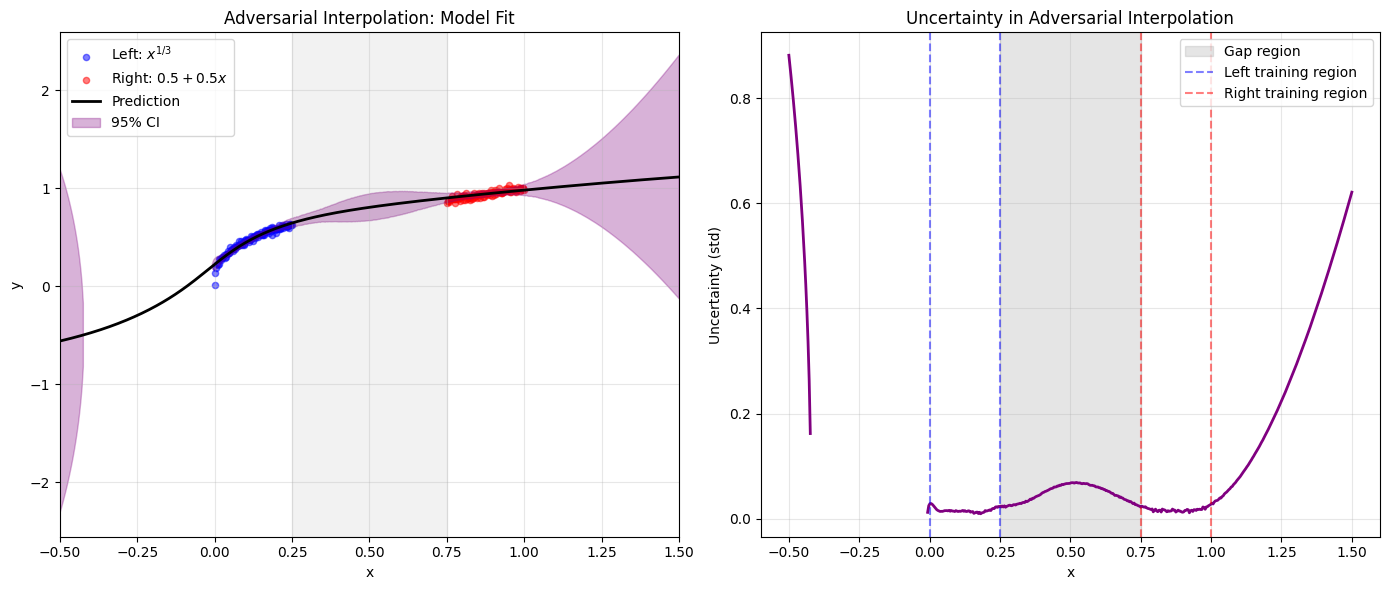

Average uncertainty in training regions: 0.0170
Average uncertainty in gap region: 0.0476
Ratio (gap/train): 2.79x

If this ratio is small, LLPR is overconfident in the gap where it's interpolating
between two incompatible functions.


In [32]:
# Plot results
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Fit plot
ax = axes[0]
ax.scatter(x_left, y_left, alpha=0.5, s=20, c="blue", label="Left: $x^{1/3}$")
ax.scatter(x_right, y_right, alpha=0.5, s=20, c="red", label="Right: $0.5+0.5x$")
ax.plot(X_test_adv, y_pred_adv, "k-", label="Prediction", linewidth=2)
ax.fill_between(
    X_test_adv.flatten(),
    y_pred_adv - 2 * y_std_adv,
    y_pred_adv + 2 * y_std_adv,
    alpha=0.3,
    color="purple",
    label="95% CI",
)
ax.axvspan(0.25, 0.75, alpha=0.1, color="gray")
ax.set_xlim(-0.5, 1.5)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend()
ax.set_title("Adversarial Interpolation: Model Fit")
ax.grid(True, alpha=0.3)

# Uncertainty plot
ax = axes[1]
ax.plot(X_test_adv, y_std_adv, "purple", linewidth=2)
ax.axvspan(0.25, 0.75, alpha=0.2, color="gray", label="Gap region")
ax.axvline(0, color="blue", linestyle="--", alpha=0.5)
ax.axvline(0.25, color="blue", linestyle="--", alpha=0.5, label="Left training region")
ax.axvline(0.75, color="red", linestyle="--", alpha=0.5)
ax.axvline(1.0, color="red", linestyle="--", alpha=0.5, label="Right training region")
ax.set_xlabel("x")
ax.set_ylabel("Uncertainty (std)")
ax.legend()
ax.set_title("Uncertainty in Adversarial Interpolation")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analysis
gap_mask = (X_test_adv.flatten() > 0.25) & (X_test_adv.flatten() < 0.75)
train_mask = ((X_test_adv.flatten() >= 0) & (X_test_adv.flatten() <= 0.25)) | (
    (X_test_adv.flatten() >= 0.75) & (X_test_adv.flatten() <= 1.0)
)

print(f"Average uncertainty in training regions: {np.mean(y_std_adv[train_mask]):.4f}")
print(f"Average uncertainty in gap region: {np.mean(y_std_adv[gap_mask]):.4f}")
print(f"Ratio (gap/train): {np.mean(y_std_adv[gap_mask]) / np.mean(y_std_adv[train_mask]):.2f}x")
print("\nIf this ratio is small, LLPR is overconfident in the gap where it's interpolating")
print("between two incompatible functions.")

*Note:* I am not sure what the gap on the right hand graph is.

## Study 7: Near-Duplicate Training Points

**Pathology:** When many training points map to nearly identical feature vectors (clustered data), F^T F becomes rank-deficient in certain directions. The matrix only "sees" the directions spanned by the cluster, leaving other directions with weak coverage.

**Expected failure mode:**
1. Points that map to features similar to the cluster will have low uncertainty (well-covered direction)
2. Points that map to features orthogonal to the cluster will have high uncertainty
3. But if a wrong prediction happens to align with cluster features, LLPR will be overconfident

**Setup:** We create heavily clustered training data where many points are near-duplicates, then test if LLPR correctly handles uncertainty for points outside the cluster.

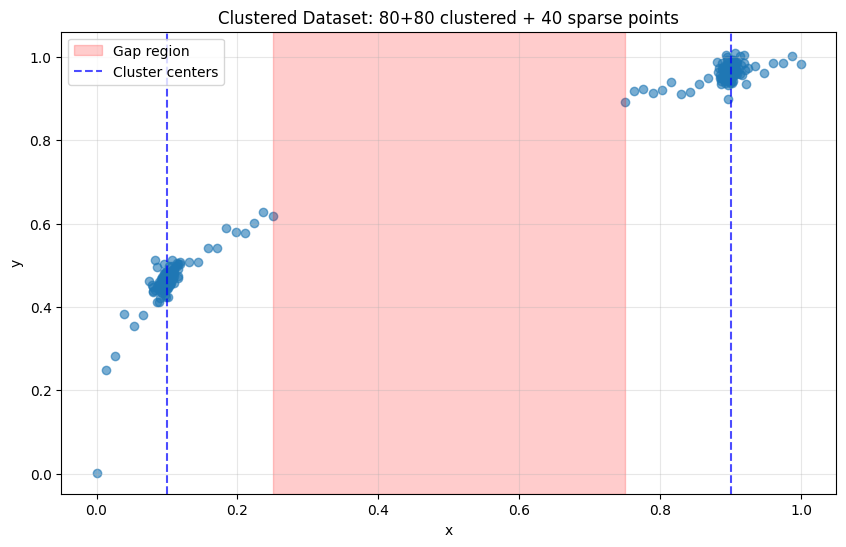

Total training points: 200
Points in cluster 1 (x≈0.1): 80
Points in cluster 2 (x≈0.9): 80
Sparse points: 40


In [33]:
# Create clustered training data with near-duplicates
np.random.seed(42)

# Cluster 1: Many points tightly clustered around x=0.1
n_cluster1 = 80
x_cluster1 = 0.1 + np.random.normal(0, 0.01, n_cluster1)  # Very tight cluster
x_cluster1 = np.clip(x_cluster1, 0, 0.25)

# Cluster 2: Many points tightly clustered around x=0.9
n_cluster2 = 80
x_cluster2 = 0.9 + np.random.normal(0, 0.01, n_cluster2)  # Very tight cluster
x_cluster2 = np.clip(x_cluster2, 0.75, 1.0)

# A few sparse points to provide some spread
n_sparse = 40
x_sparse_left = np.linspace(0.0, 0.25, n_sparse // 2)
x_sparse_right = np.linspace(0.75, 1.0, n_sparse // 2)

X_train_clustered = np.concatenate([x_cluster1, x_cluster2, x_sparse_left, x_sparse_right])
y_train_clustered = np.cbrt(X_train_clustered) + np.random.normal(0, 0.02, X_train_clustered.shape)
X_train_clustered = X_train_clustered.reshape(-1, 1)

# Plot the clustered dataset
plt.figure(figsize=(10, 6))
plt.scatter(X_train_clustered, y_train_clustered, alpha=0.6)
plt.axvspan(0.25, 0.75, alpha=0.2, color="red", label="Gap region")

# Highlight clusters
plt.axvline(0.1, color="blue", linestyle="--", alpha=0.7, label="Cluster centers")
plt.axvline(0.9, color="blue", linestyle="--", alpha=0.7)

plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title(f"Clustered Dataset: {n_cluster1}+{n_cluster2} clustered + {n_sparse} sparse points")
plt.grid(True, alpha=0.3)
plt.show()

print(f"Total training points: {len(X_train_clustered)}")
print(f"Points in cluster 1 (x≈0.1): {n_cluster1}")
print(f"Points in cluster 2 (x≈0.9): {n_cluster2}")
print(f"Sparse points: {n_sparse}")

In [34]:
# Train model on clustered data
print("Training on clustered dataset...")
model_clustered = LLPRRegressor(
    hidden_dims=(32, 32),
    activation="tanh",
    learning_rate=1e-3,
    n_epochs=500,
    batch_size=32,
    early_stopping_patience=100,
    alpha_squared="auto",
    zeta_squared="auto",
    val_size=0.1,
    random_state=42,
)
model_clustered.fit(X_train_clustered, y_train_clustered)

# Also train on uniformly distributed data for comparison
print("\nTraining on uniform dataset for comparison...")
x_uniform = np.concatenate([np.linspace(0, 0.25, 100), np.linspace(0.75, 1.0, 100)])
y_uniform = np.cbrt(x_uniform) + np.random.normal(0, 0.02, x_uniform.shape)
X_train_uniform = x_uniform.reshape(-1, 1)

model_uniform = LLPRRegressor(
    hidden_dims=(32, 32),
    activation="tanh",
    learning_rate=1e-3,
    n_epochs=500,
    batch_size=32,
    early_stopping_patience=100,
    alpha_squared="auto",
    zeta_squared="auto",
    val_size=0.1,
    random_state=42,
)
model_uniform.fit(X_train_uniform, y_uniform)

Training on clustered dataset...
Early stopping at epoch 201
Calibrated: alpha²=1.00e-02, zeta²=4.28e-04, NLL=-2.7659

Training on uniform dataset for comparison...
Early stopping at epoch 143
Calibrated: alpha²=2.64e-02, zeta²=2.64e-08, NLL=-2.3376


LLPRRegressor(activation='tanh', hidden_dims=(32, 32), n_epochs=500)

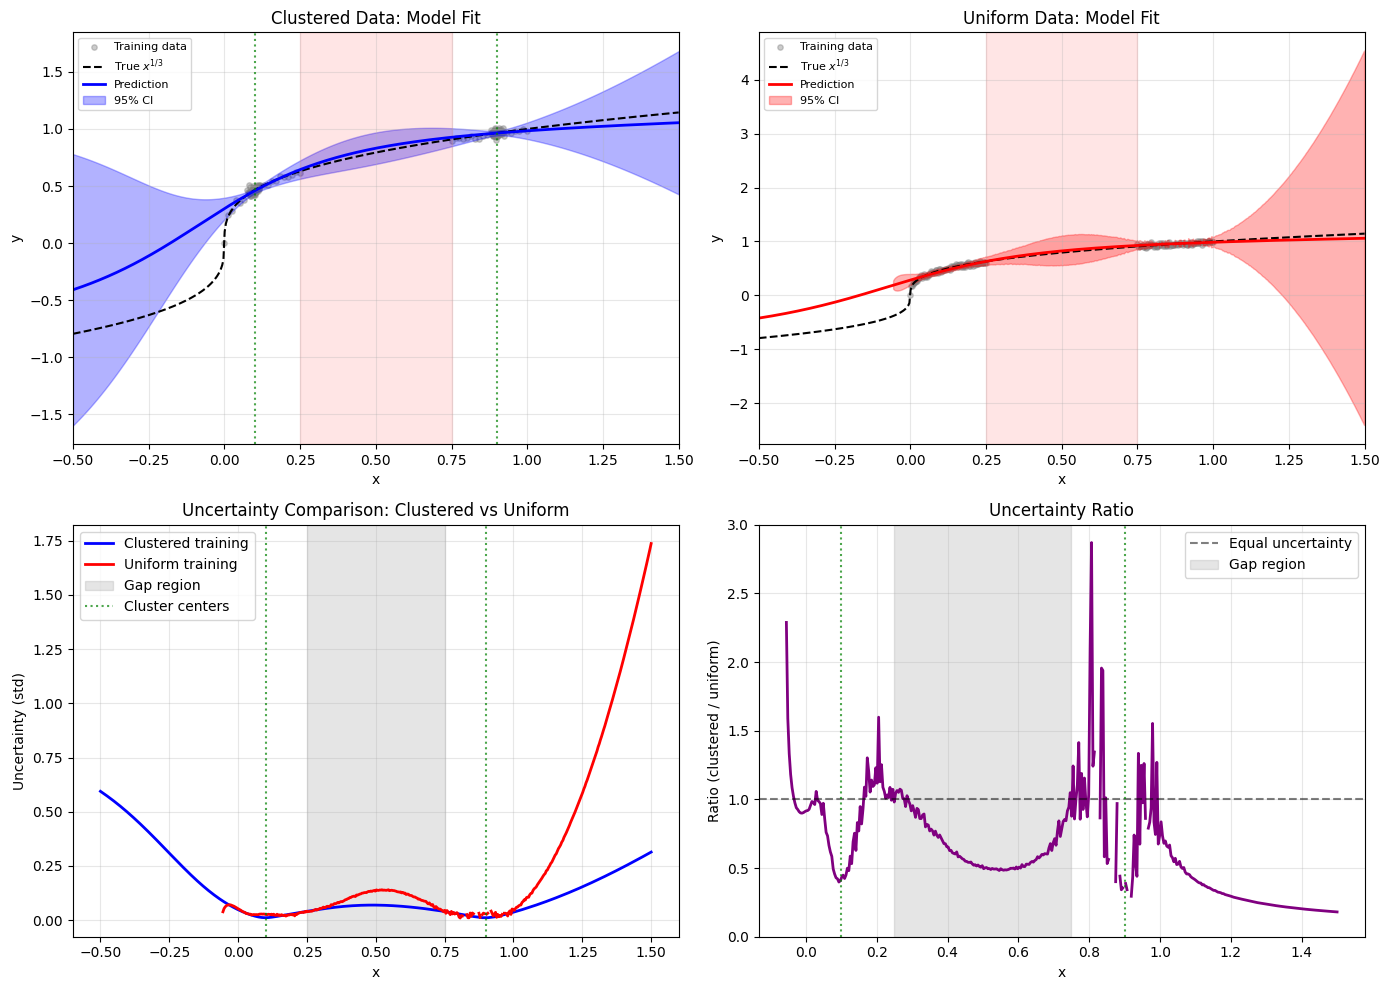

In [35]:
# Generate predictions
X_test_cluster = np.linspace(-0.5, 1.5, 500).reshape(-1, 1)
y_pred_clustered, y_std_clustered = model_clustered.predict_with_uncertainty(X_test_cluster)
y_pred_uniform, y_std_uniform = model_uniform.predict_with_uncertainty(X_test_cluster)

# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

x_true = np.linspace(-0.5, 1.5, 500)
y_true = np.cbrt(x_true)

# Clustered - fit
ax = axes[0, 0]
ax.scatter(X_train_clustered, y_train_clustered, alpha=0.4, s=15, c="gray", label="Training data")
ax.plot(x_true, y_true, "k--", label="True $x^{1/3}$", linewidth=1.5)
ax.plot(X_test_cluster, y_pred_clustered, "b-", label="Prediction", linewidth=2)
ax.fill_between(
    X_test_cluster.flatten(),
    y_pred_clustered - 2 * y_std_clustered,
    y_pred_clustered + 2 * y_std_clustered,
    alpha=0.3,
    color="blue",
    label="95% CI",
)
ax.axvspan(0.25, 0.75, alpha=0.1, color="red")
ax.axvline(0.1, color="green", linestyle=":", alpha=0.7)
ax.axvline(0.9, color="green", linestyle=":", alpha=0.7)
ax.set_xlim(-0.5, 1.5)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend(fontsize=8)
ax.set_title("Clustered Data: Model Fit")
ax.grid(True, alpha=0.3)

# Uniform - fit
ax = axes[0, 1]
ax.scatter(X_train_uniform, y_uniform, alpha=0.4, s=15, c="gray", label="Training data")
ax.plot(x_true, y_true, "k--", label="True $x^{1/3}$", linewidth=1.5)
ax.plot(X_test_cluster, y_pred_uniform, "r-", label="Prediction", linewidth=2)
ax.fill_between(
    X_test_cluster.flatten(),
    y_pred_uniform - 2 * y_std_uniform,
    y_pred_uniform + 2 * y_std_uniform,
    alpha=0.3,
    color="red",
    label="95% CI",
)
ax.axvspan(0.25, 0.75, alpha=0.1, color="red")
ax.set_xlim(-0.5, 1.5)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend(fontsize=8)
ax.set_title("Uniform Data: Model Fit")
ax.grid(True, alpha=0.3)

# Uncertainty comparison
ax = axes[1, 0]
ax.plot(X_test_cluster, y_std_clustered, "b-", label="Clustered training", linewidth=2)
ax.plot(X_test_cluster, y_std_uniform, "r-", label="Uniform training", linewidth=2)
ax.axvspan(0.25, 0.75, alpha=0.2, color="gray", label="Gap region")
ax.axvline(0.1, color="green", linestyle=":", alpha=0.7, label="Cluster centers")
ax.axvline(0.9, color="green", linestyle=":", alpha=0.7)
ax.set_xlabel("x")
ax.set_ylabel("Uncertainty (std)")
ax.legend()
ax.set_title("Uncertainty Comparison: Clustered vs Uniform")
ax.grid(True, alpha=0.3)

# Ratio of uncertainties
ax = axes[1, 1]
ratio = y_std_clustered / (y_std_uniform + 1e-10)
ax.plot(X_test_cluster, ratio, "purple", linewidth=2)
ax.axhline(1, color="k", linestyle="--", alpha=0.5, label="Equal uncertainty")
ax.axvspan(0.25, 0.75, alpha=0.2, color="gray", label="Gap region")
ax.axvline(0.1, color="green", linestyle=":", alpha=0.7)
ax.axvline(0.9, color="green", linestyle=":", alpha=0.7)
ax.set_xlabel("x")
ax.set_ylabel("Ratio (clustered / uniform)")
ax.legend()
ax.set_title("Uncertainty Ratio")
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 3)

plt.tight_layout()
plt.show()

In [36]:
# Analyze F^T F condition number for clustered vs uniform
import jax.numpy as jnp

# Get training features for both models
_, features_clustered = model_clustered.model_.apply(
    model_clustered.params_, jnp.array(X_train_clustered, dtype=jnp.float32), return_features=True
)
_, features_uniform_train = model_uniform.model_.apply(
    model_uniform.params_, jnp.array(X_train_uniform, dtype=jnp.float32), return_features=True
)

features_clustered = np.array(features_clustered)
features_uniform_train = np.array(features_uniform_train)

# Compute F^T F
FTF_clustered = features_clustered.T @ features_clustered
FTF_uniform = features_uniform_train.T @ features_uniform_train

# Eigenvalue analysis
eigvals_clustered = np.linalg.eigvalsh(FTF_clustered)
eigvals_uniform = np.linalg.eigvalsh(FTF_uniform)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Eigenvalue spectrum
ax = axes[0]
ax.semilogy(
    range(len(eigvals_clustered)),
    np.sort(eigvals_clustered)[::-1],
    "b-o",
    label="Clustered",
    markersize=4,
)
ax.semilogy(
    range(len(eigvals_uniform)),
    np.sort(eigvals_uniform)[::-1],
    "r-o",
    label="Uniform",
    markersize=4,
)
ax.set_xlabel("Eigenvalue index")
ax.set_ylabel("Eigenvalue (log scale)")
ax.legend()
ax.set_title("Eigenvalue Spectrum of F^T F")
ax.grid(True, alpha=0.3)

# Condition number comparison
ax = axes[1]
cond_clustered = np.max(eigvals_clustered) / (np.min(eigvals_clustered) + 1e-10)
cond_uniform = np.max(eigvals_uniform) / (np.min(eigvals_uniform) + 1e-10)

bars = ax.bar(
    ["Clustered", "Uniform"], [cond_clustered, cond_uniform], color=["steelblue", "coral"]
)
ax.set_ylabel("Condition Number")
ax.set_title("Condition Number of F^T F\n(Higher = more ill-conditioned)")
ax.set_yscale("log")
ax.grid(True, alpha=0.3, axis="y")

for bar, val in zip(bars, [cond_clustered, cond_uniform]):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{val:.1e}",
        ha="center",
        va="bottom",
        fontsize=10,
    )

plt.tight_layout()
plt.show()

print(
    f"Clustered data: condition number = {cond_clustered:.2e}, ζ² = {model_clustered.zeta_squared_:.2e}"
)
print(
    f"Uniform data: condition number = {cond_uniform:.2e}, ζ² = {model_uniform.zeta_squared_:.2e}"
)
print("\nNear-duplicate points in clusters cause F^T F to be ill-conditioned,")
print("as many training features are nearly identical.")

/var/folders/1f/n8r80n0n5zn2l9h7ghmb94fw0000gn/T/ipykernel_76108/3076890281.py:50: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')
/var/folders/1f/n8r80n0n5zn2l9h7ghmb94fw0000gn/T/ipykernel_76108/3076890281.py:57: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


Clustered data: condition number = -1.69e+07, ζ² = 4.28e-04
Uniform data: condition number = -1.75e+07, ζ² = 2.64e-08

Near-duplicate points in clusters cause F^T F to be ill-conditioned,
as many training features are nearly identical.


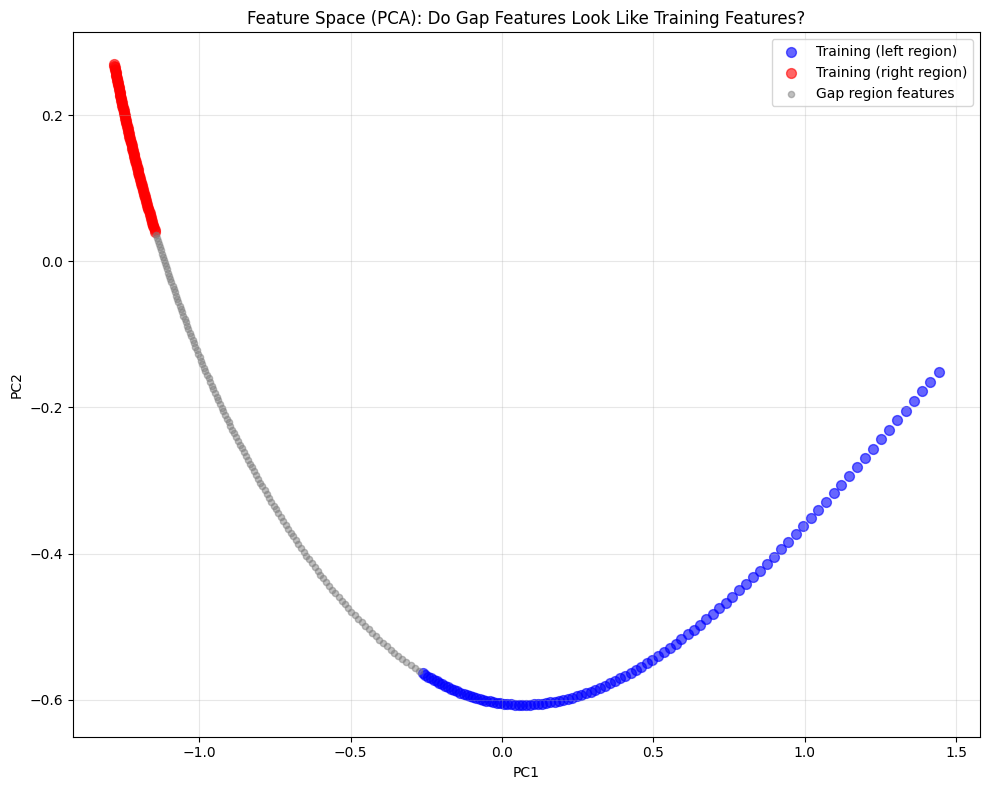

If gap features (gray) lie within the span of training features (blue/red),
LLPR will report low uncertainty despite the model being wrong there.


In [37]:
# Examine feature space to understand why gap might have low uncertainty
import jax.numpy as jnp

# Get features for test points
_, features_adv = model_adv.model_.apply(
    model_adv.params_, jnp.array(X_test_adv, dtype=jnp.float32), return_features=True
)
features_adv = np.array(features_adv)

# Get features for training points
_, features_train_adv = model_adv.model_.apply(
    model_adv.params_, jnp.array(X_train_adv, dtype=jnp.float32), return_features=True
)
features_train_adv = np.array(features_train_adv)

# PCA to visualize feature space
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
features_all = np.vstack([features_train_adv, features_adv])
pca.fit(features_all)

features_train_pca = pca.transform(features_train_adv)
features_test_pca = pca.transform(features_adv)

# Plot feature space
fig, ax = plt.subplots(figsize=(10, 8))

# Training points
left_mask_train = X_train_adv.flatten() < 0.5
ax.scatter(
    features_train_pca[left_mask_train, 0],
    features_train_pca[left_mask_train, 1],
    c="blue",
    s=50,
    alpha=0.6,
    label="Training (left region)",
)
ax.scatter(
    features_train_pca[~left_mask_train, 0],
    features_train_pca[~left_mask_train, 1],
    c="red",
    s=50,
    alpha=0.6,
    label="Training (right region)",
)

# Test points colored by region
gap_mask_test = (X_test_adv.flatten() > 0.25) & (X_test_adv.flatten() < 0.75)
ax.scatter(
    features_test_pca[gap_mask_test, 0],
    features_test_pca[gap_mask_test, 1],
    c="gray",
    s=20,
    alpha=0.5,
    label="Gap region features",
)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.legend()
ax.set_title("Feature Space (PCA): Do Gap Features Look Like Training Features?")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("If gap features (gray) lie within the span of training features (blue/red),")
print("LLPR will report low uncertainty despite the model being wrong there.")

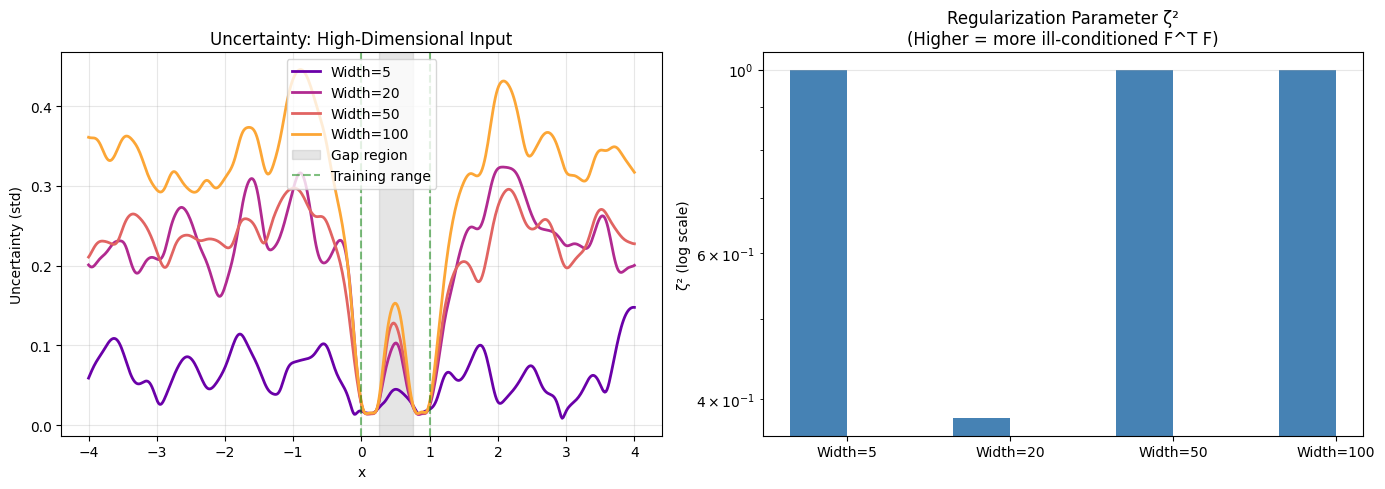

Analysis: Large ζ² indicates the calibration found F^T F to be ill-conditioned.
When ζ² dominates, uncertainty ≈ α²/ζ² * ||f★||², losing the covariance structure.


In [38]:
# Uncertainty comparison and analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Uncertainty plot
ax = axes[0]
for width, color in zip(highdim_widths, colors):
    y_pred, y_std = predictions_highdim[width]
    ax.plot(X_test_raw_highdim, y_std, color=color, label=f"Width={width}", linewidth=2)

ax.axvspan(0.25, 0.75, alpha=0.2, color="gray", label="Gap region")
ax.axvline(0, color="green", linestyle="--", alpha=0.5)
ax.axvline(1, color="green", linestyle="--", alpha=0.5, label="Training range")
ax.set_xlabel("x")
ax.set_ylabel("Uncertainty (std)")
ax.legend()
ax.set_title("Uncertainty: High-Dimensional Input")
ax.grid(True, alpha=0.3)

# Show ζ² values - indicator of ill-conditioning
ax = axes[1]
zeta_values = [models_highdim[w].zeta_squared_ for w in highdim_widths]
alpha_values = [models_highdim[w].alpha_squared_ for w in highdim_widths]
x_pos = np.arange(len(highdim_widths))
width_bar = 0.35

bars1 = ax.bar(x_pos - width_bar / 2, zeta_values, width_bar, label="ζ²", color="steelblue")
ax.set_yscale("log")
ax.set_xticks(x_pos)
ax.set_xticklabels([f"Width={w}" for w in highdim_widths])
ax.set_ylabel("ζ² (log scale)")
ax.set_title("Regularization Parameter ζ²\n(Higher = more ill-conditioned F^T F)")
ax.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

print("Analysis: Large ζ² indicates the calibration found F^T F to be ill-conditioned.")
print("When ζ² dominates, uncertainty ≈ α²/ζ² * ||f★||², losing the covariance structure.")

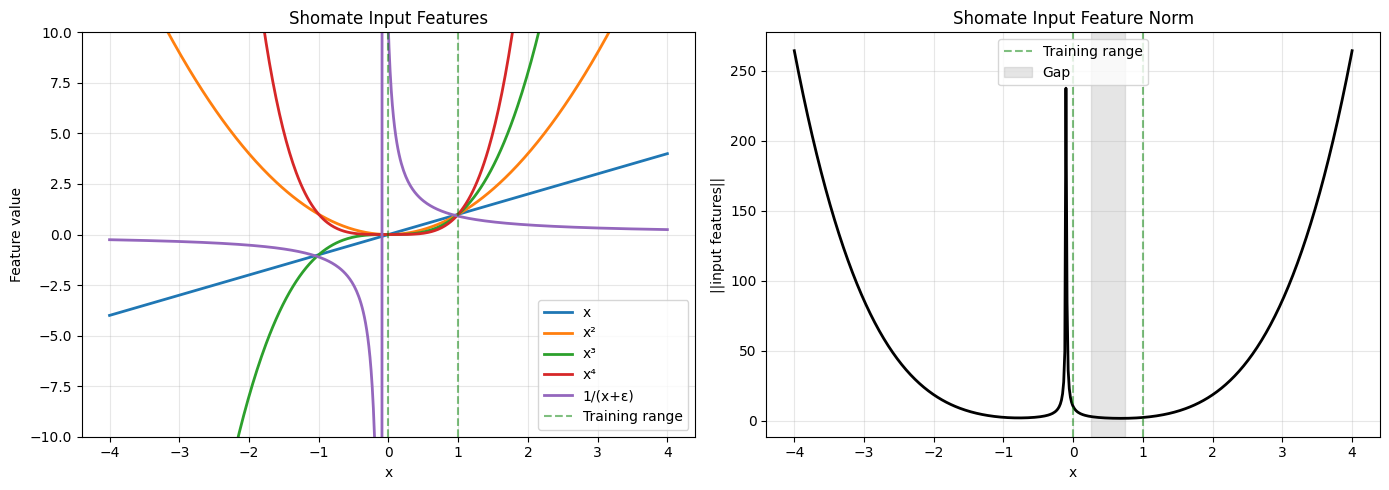

Note: Polynomial features (x³, x⁴) grow rapidly in extrapolation,
which may cause the network to see very different inputs than during training.


In [39]:
# Visualize how Shomate features behave in extrapolation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot the raw Shomate features
ax = axes[0]
feature_names = ["x", "x²", "x³", "x⁴", "1/(x+ε)"]
for i, name in enumerate(feature_names):
    ax.plot(X_test_shomate_raw, X_test_shomate[:, i], label=name, linewidth=2)
ax.axvline(0, color="green", linestyle="--", alpha=0.5)
ax.axvline(1, color="green", linestyle="--", alpha=0.5, label="Training range")
ax.set_xlabel("x")
ax.set_ylabel("Feature value")
ax.set_title("Shomate Input Features")
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(-10, 10)

# Plot the input feature norms
ax = axes[1]
input_norms = np.linalg.norm(X_test_shomate, axis=1)
ax.plot(X_test_shomate_raw, input_norms, "k-", linewidth=2)
ax.axvline(0, color="green", linestyle="--", alpha=0.5)
ax.axvline(1, color="green", linestyle="--", alpha=0.5, label="Training range")
ax.axvspan(0.25, 0.75, alpha=0.2, color="gray", label="Gap")
ax.set_xlabel("x")
ax.set_ylabel("||input features||")
ax.set_title("Shomate Input Feature Norm")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Note: Polynomial features (x³, x⁴) grow rapidly in extrapolation,")
print("which may cause the network to see very different inputs than during training.")